# Time Series - Part 2 Modeling
In this second notebook we provide a short introduction of the modeling techniques for time series. 

The content of this notebook is based on 
* Rob J Hyndman and George Athanasopoulos. Forecasting: Principles and Practice available at https://otexts.com/fpp2/
* Siddharth Yadav [Everything you can do with a time series](https://www.kaggle.com/thebrownviking20/everything-you-can-do-with-a-time-series#3.-Time-series-decomposition-and-Random-walks)
* Selva Prabhakaran [Time Series Analysis in Python – A Comprehensive Guide with Examples](https://www.machinelearningplus.com/time-series/time-series-analysis-python/)
* Rob Reider DataCamp course: [Time Series Analysis in Python](https://learn.datacamp.com/courses/time-series-analysis-in-python)
* James Fulton DataCamp course: [ARIMA Models in Python](https://learn.datacamp.com/courses/arima-models-in-python)

There is an interesting page containing all the guidelines about methods to transform data for forecasting models and when to apply at http://people.duke.edu/~rnau/whatuse.htm

In [1]:
import pandas as pd
import numpy as np
import math
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# select the style from fivethityeight website
plt.style.use('fivethirtyeight') 
mpl.rcParams['lines.linewidth'] = 2

# predefined figsize
figsize=(12,9)

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

# Data Exploration
As we did at the beginning of the course, we start by exploring some of the techniques that can be used to explore time series data.

## Let's load some data
We load some publicly available data that we will be using in this notebook. If you are looking for othe datasets to experiment with check out https://datasetsearch.research.google.com

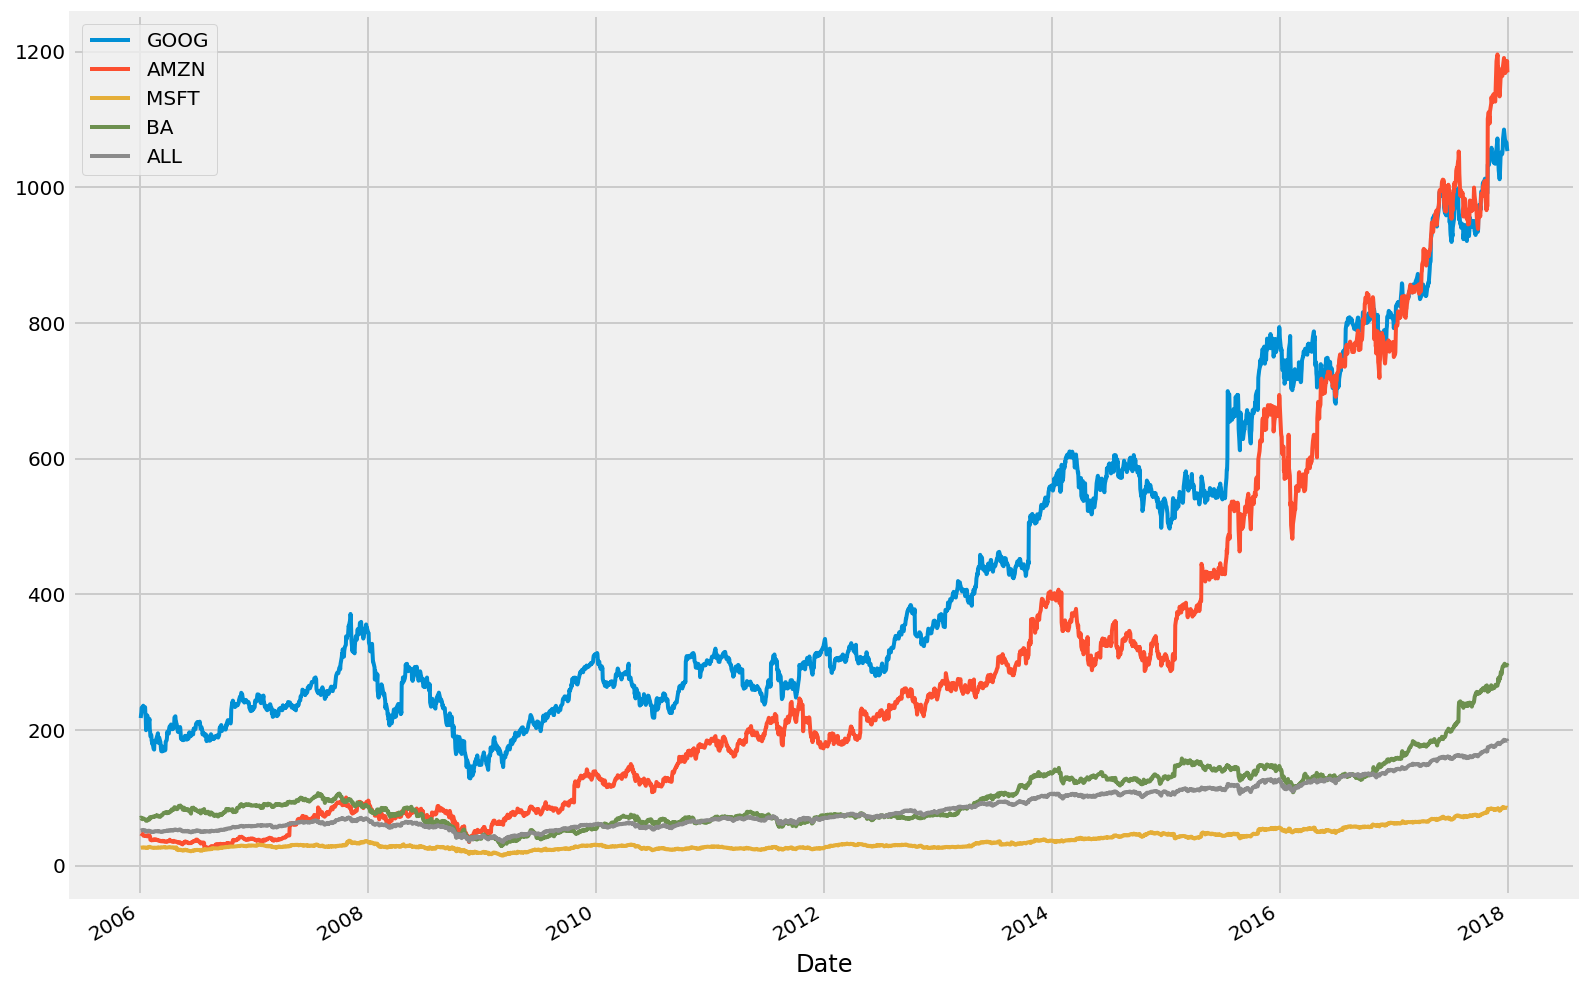

In [2]:
google = pd.read_csv('stocks/GOOGL_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
amazon = pd.read_csv('stocks/AMZN_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
microsoft = pd.read_csv('stocks/MSFT_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
boeing = pd.read_csv('stocks/BA_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
all_stocks = pd.read_csv('stocks/all_stocks_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
all_stocks = all_stocks.groupby('Date').mean()

google_diet = pd.read_csv('others/google_search_diet.csv', index_col='Month', parse_dates=['Month'])

amazon_revenues = pd.read_csv('others/amazon-revenues.csv', index_col='Q', parse_dates=['Q'])


# generate a data frame with some of the stock prices
stocks = google.Close.to_frame('GOOG')
stocks = stocks.join(amazon.Close.to_frame('AMZN'))
stocks = stocks.join(microsoft.Close.to_frame('MSFT'))
stocks = stocks.join(boeing.Close.to_frame('BA'))
stocks = stocks.join(all_stocks.Close.to_frame('ALL'))

stocks.plot(figsize=figsize);

## Correlation
We can measure the correlation between pairs of series to measures how much two time series varies together. For two numerical variables, we can compute Peaeson's product moment coefficient as, 

<font size="3">
$
r_{xy} = \frac{\sum_{i=1}^n (x_i-\overline{x})(y_i-\overline{y})}{\sigma_x \sigma_y}
$
</font>

A high correlation means that the two series strongly vary together (when one increases, the other one also increases; when one decreases, the other one decreases as well). A low correlation means that they vary together but they is a weak association. Finally, a high negative correlation means that they vary in opposite directions but there is still a linear relationship.

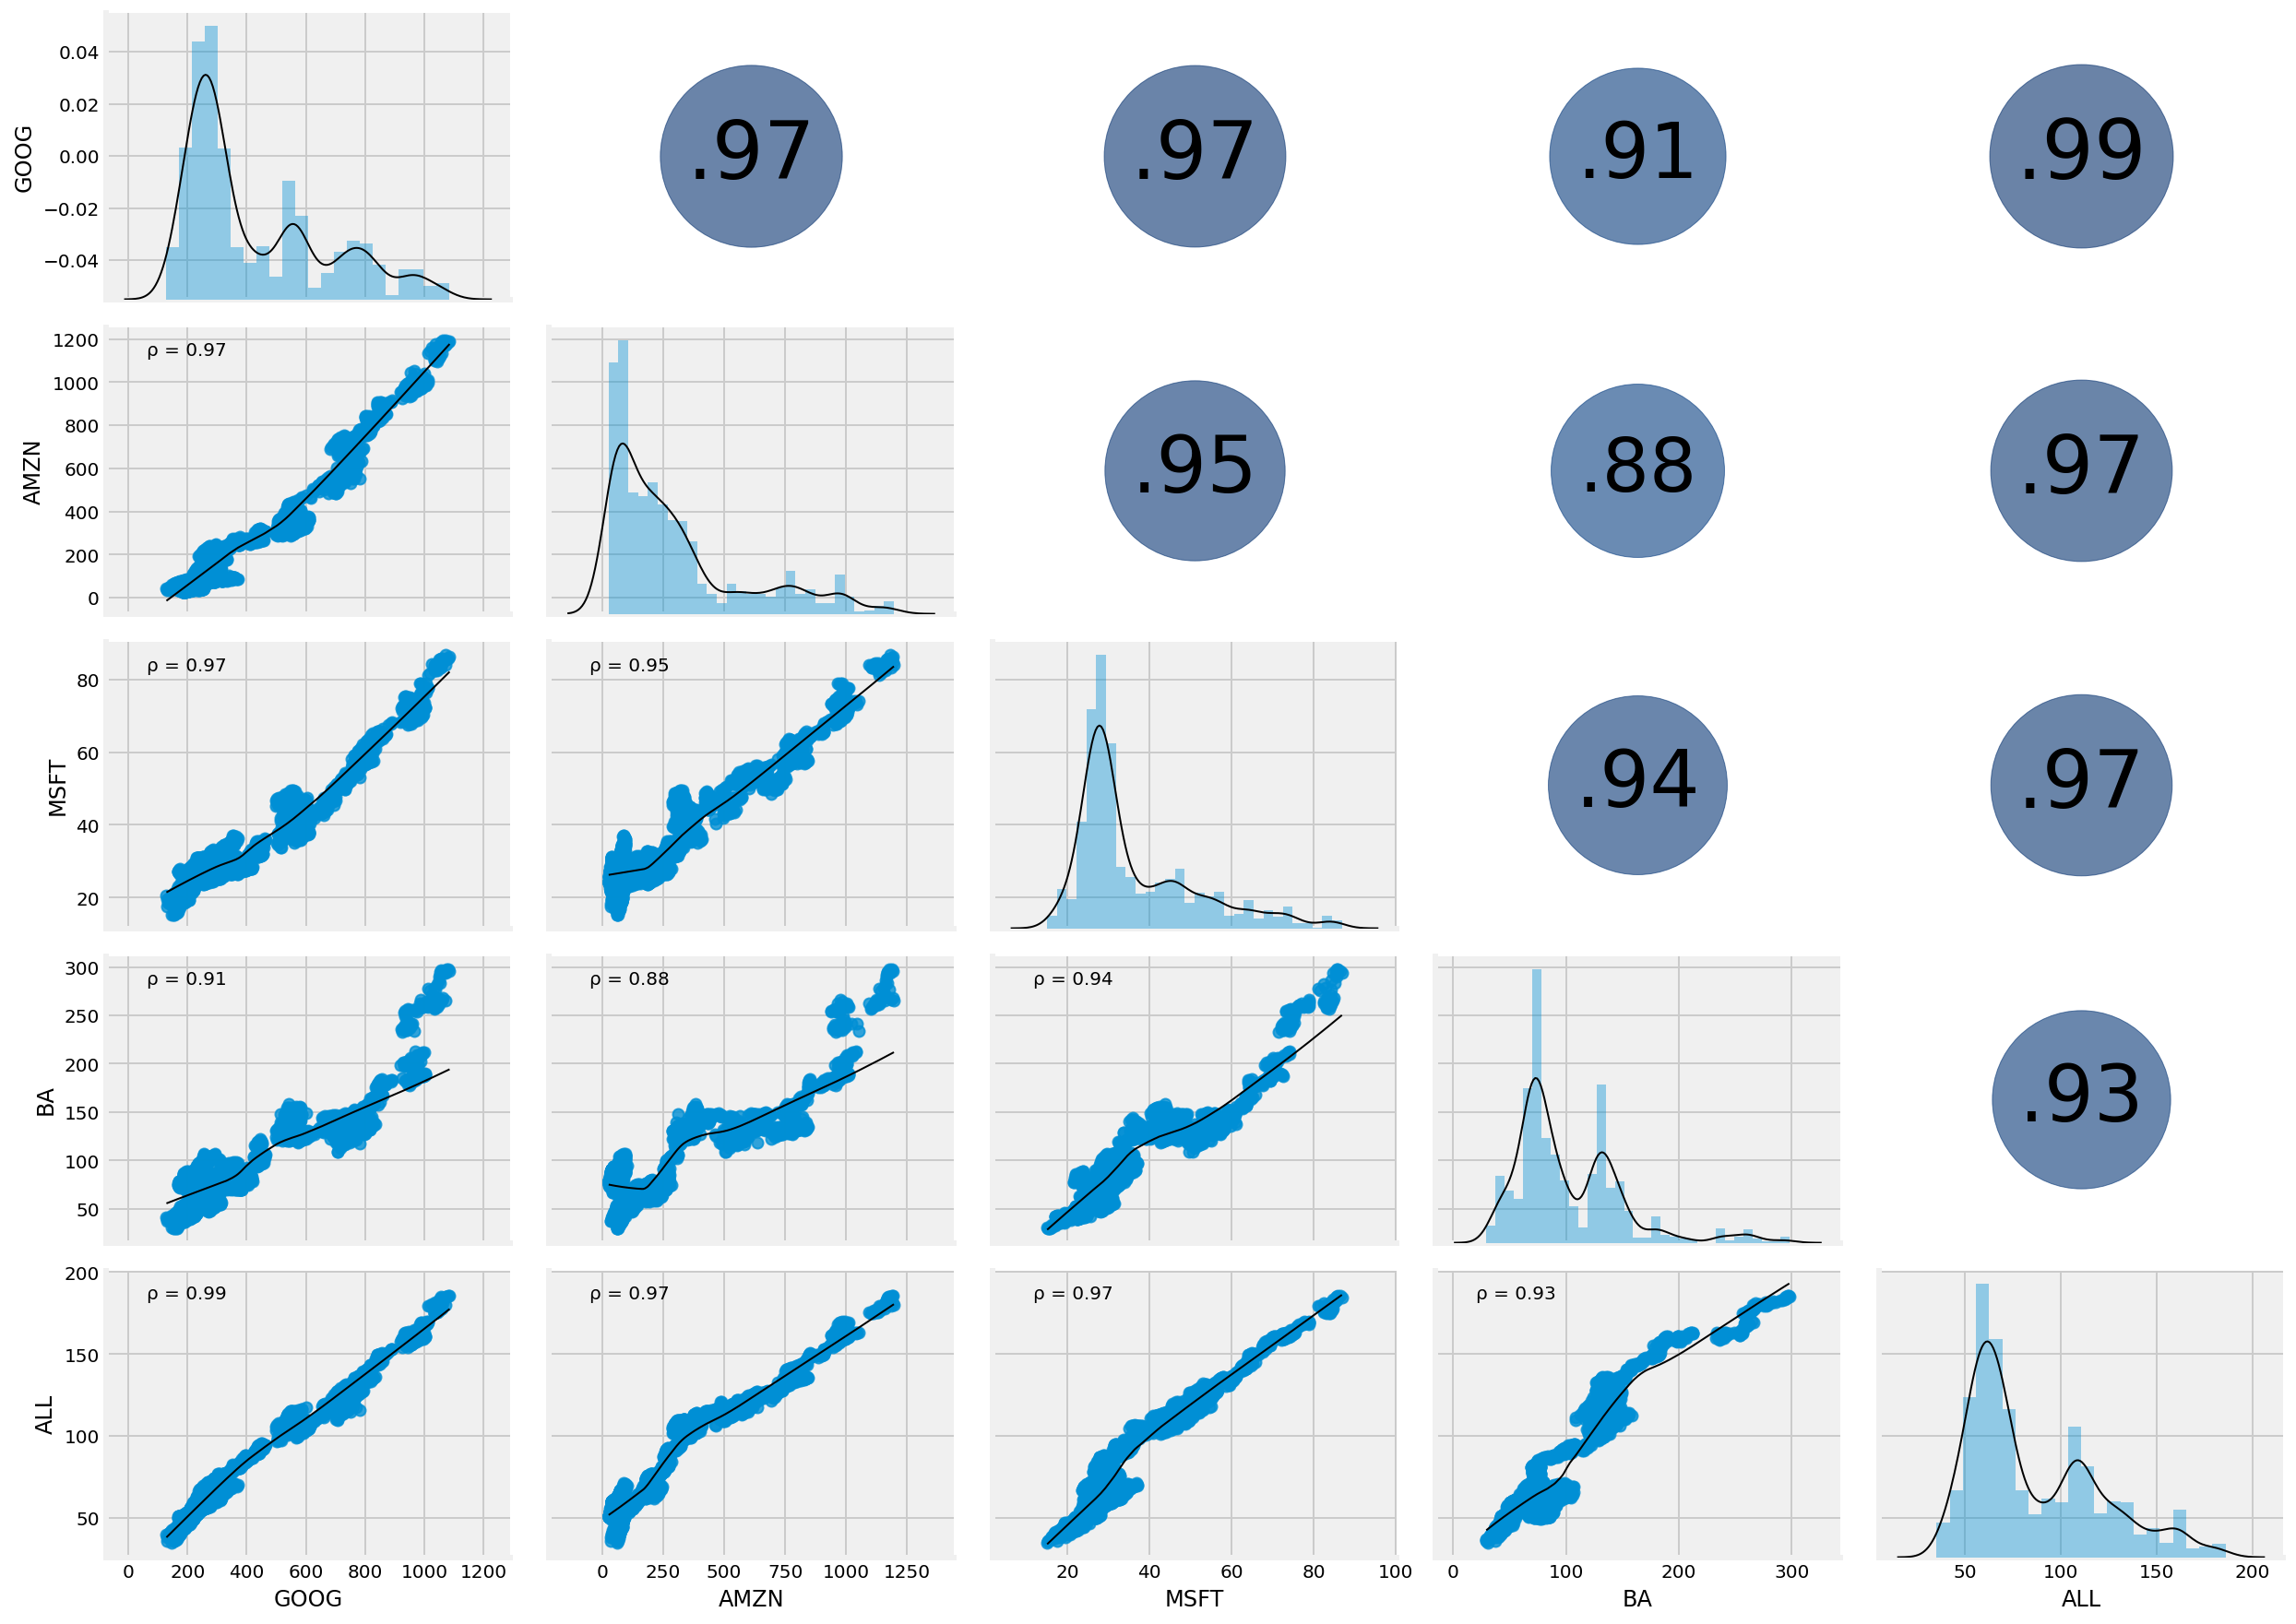

In [3]:
from scipy.stats import pearsonr

def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = '\u03C1'
    ax.annotate(f'{rho} = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="Blues",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)    
    
# g = sns.pairplot(stocks,palette=["Blues_d"])
g = sns.PairGrid(stocks, aspect=1.4, diag_sharey=False)
g.map_lower(corrfunc)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'Black','linewidth':1})
g.map_diag(sns.distplot, kde_kws={'color': 'Black','linewidth':1})
g.map_upper(corrdot)
plt.show()

As can be noted correlations are very high even if the plots show quite different trends. For instance, GOOG and BA have a correlation of 0.91 although the time series are quite different. We can have high correlations between completely unrelated phenomena, as shown in this [page](https://www.tylervigen.com/spurious-correlations) 

Instead of measuring the correlation among the raw data, it is better to measure the correlation of percent changes ($pct\_change$) which is the case of stocks represents the daily return. 

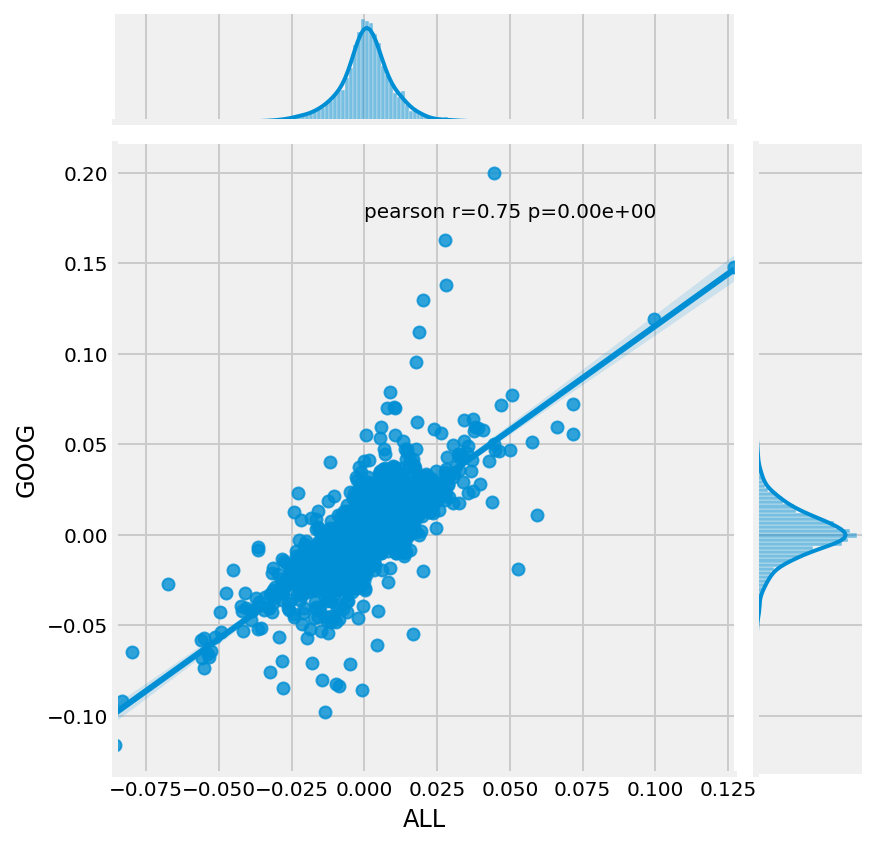

In [28]:
daily_returns = stocks.pct_change().dropna()
g = sns.jointplot(x='ALL', y='GOOG', data=daily_returns, kind='reg');
r,p = pearsonr(daily_returns['ALL'],daily_returns['GOOG'])
g.ax_joint.text(x=0.0,y=0.175,s="pearson r={:.2f} p={:.2e}".format(r,p));

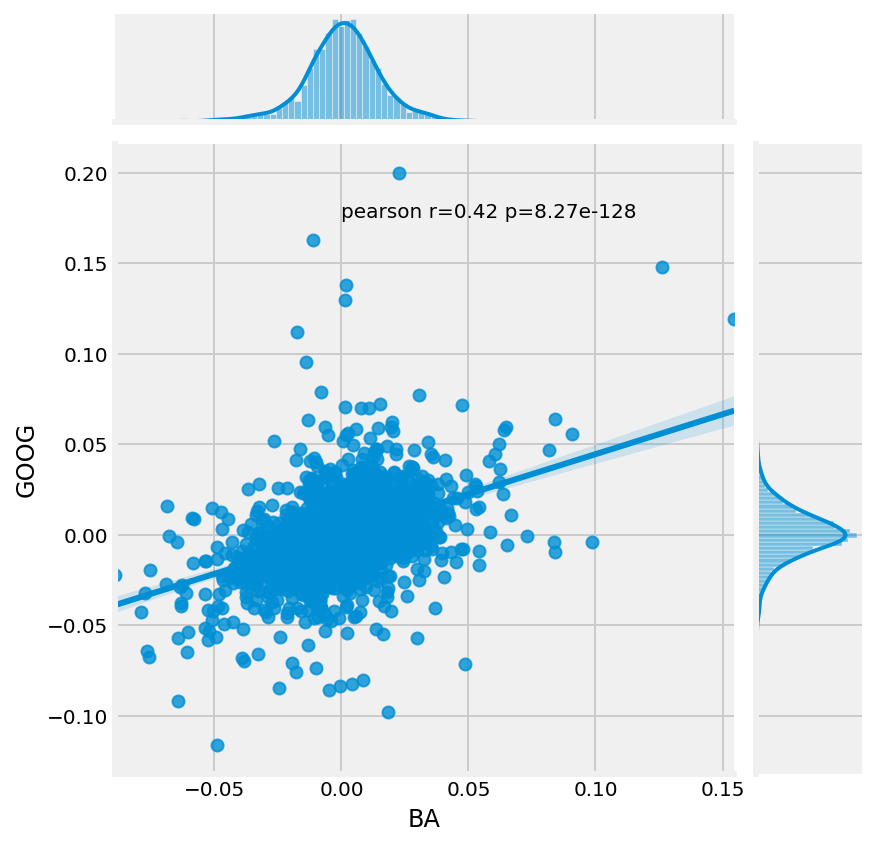

In [27]:
g = sns.jointplot(x='BA', y='GOOG', data=daily_returns, kind='reg');
# g.annotate(pearsonr);
r,p = pearsonr(daily_returns['BA'],daily_returns['GOOG'])
g.ax_joint.text(x=0.0,y=0.175,s="pearson r={:.2f} p={:.2e}".format(r,p));

In [12]:
pearsonr(daily_returns['BA'],daily_returns['GOOG'])

(0.41778075300520634, 8.271398928246529e-128)

In [9]:
pearsonr

<function scipy.stats.stats.pearsonr(x, y)>

As can be noted, the correlation between BA and GOOG dropped to 0.42 from 0.91 measured on the raw data. We can also draw the clustermap of the correlation data from daily returns.

In [ ]:
correlations=daily_returns.corr()
sns.set(font_scale=1.5)
sns.clustermap(correlations, cmap="Blues", annot=True);

## Autocorrelation Function (ACF)
So far we evaluated the correlation between two time series. Autocorrelation measures how a series is correlated with a lagged copy of itself. For a lag $k$, it is computed as,

$$
    r_k = Corr(x_t, x_{t+k})
$$

It is also referred to as serial correlation. For instance, we can compute the lag-one autocorrelation for the GOOG stock by taking the same series and shifting it by one and then compute the correlation.

In [ ]:
stocks['AMZN Lagged'] = stocks['AMZN'].shift()
stocks['AMZN Lagged'].corr(stocks['AMZN'])

or simply by using the native function as,

In [8]:
stocks['AMZN'].autocorr()

0.9997071543989714

Any substantial non-zero autocorrelations implies that the series can be forecast from the past.

In financial time series, when returns have a negative autocorrelation, we say that it is *mean reverting*; when returns have a positive autocorrelation, we say that the series is *trend following*.

We can plot the autocorrelation function (ACF) for different lags using a *correlogram*,

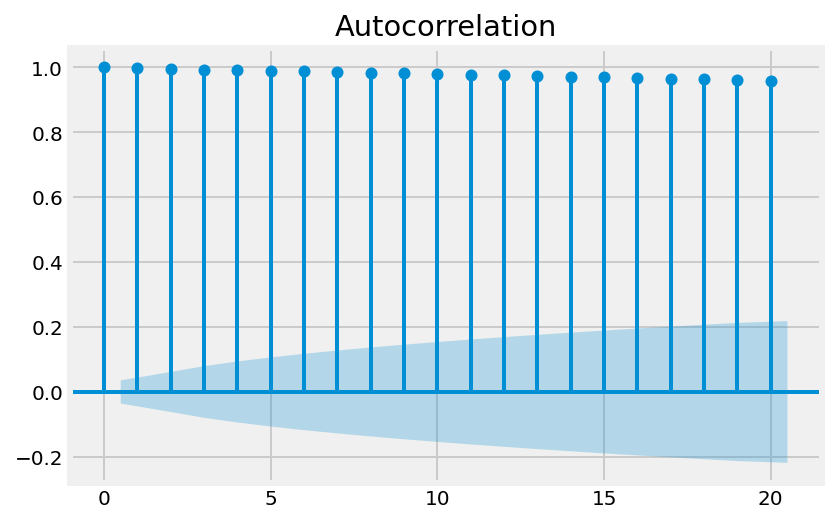

In [10]:
plot_acf(stocks['AMZN'],lags=20)
plt.show()

In [11]:
from statsmodels.tsa.stattools import adfuller

adf = adfuller(stocks['AMZN'])
print("p-value of Amazon volume: %.4f"%adf[1])

p-value of Amazon volume: 1.0000


Note that, 
* the ACF for lag 0 ($r_0$) is always 1 since it measures the correlation of the serie with itself
* the X axis reports the lag value $k$
* the blue area reports the approximate 95% confidence interval

We can also note that there is a very high autocorrelation even for a lag of 20. However, if we consider the daily returns we note that there is basically no significant autocorrelation. The first plot identifies a non-stationary series. The plot below is typical for a non-stationary series. Computing percentage change (pct_change) is a way to make a non-stationary series, stationary.

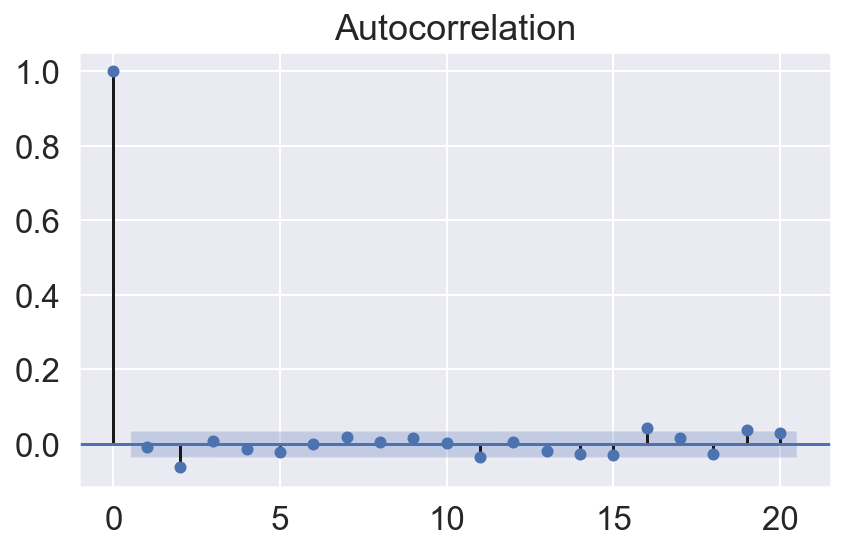

In [10]:
plot_acf(daily_returns['AMZN'],lags=20)
plt.show()

# Noise and Random Walks

White noise has constant mean and variance and zero autocorrelation with respect to all possible lags. We can for instance create a normal white noise signal with mean zero and standard deviation 1 as follows,

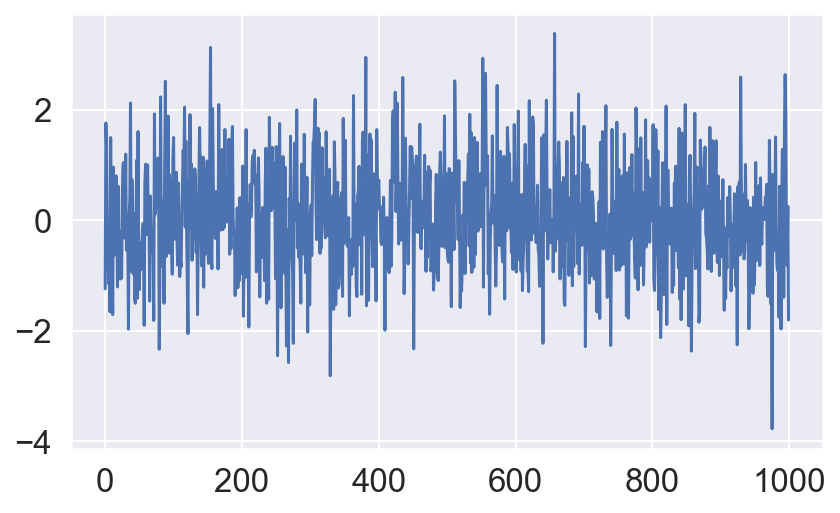

In [11]:
white_noise = np.random.normal(loc=0, scale=1, size=1000)
plt.plot(white_noise);

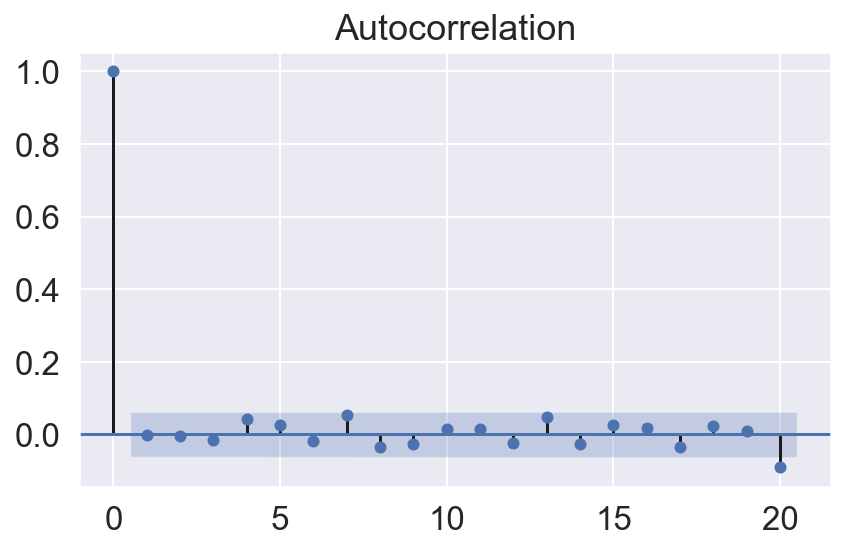

In [12]:
plot_acf(white_noise,lags=20)
plt.show()

See how all lags are not statistically significant as they lie inside the confidence interval (shaded portion). This indicates that the data series above cannot be predicted (as we should expect for white noise).

It is interesting to note that stock market returns are close to white noise like for the following examples,

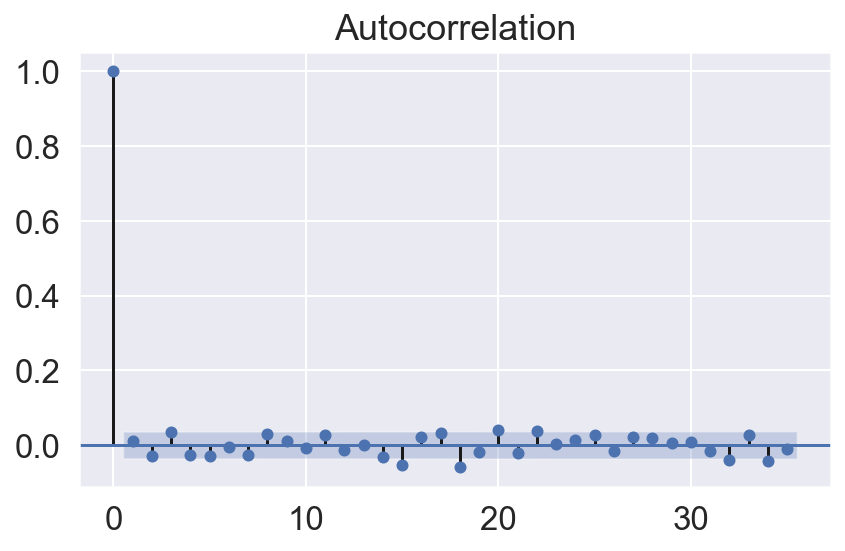

In [13]:
acf_ba = plot_acf(daily_returns['BA'].values)

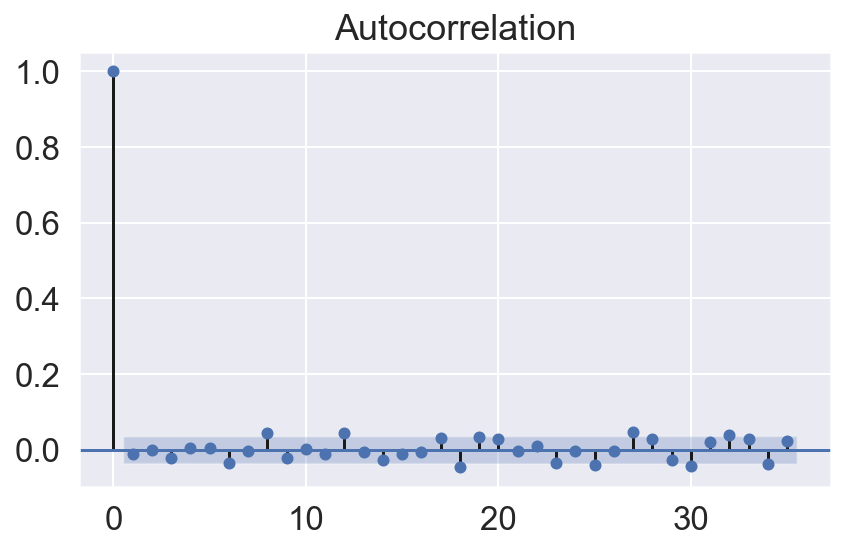

In [14]:
acf_goog = plot_acf(daily_returns['GOOG'].values)

## Random Walk

A random walk is a stochastic or random process that describes a path consisting of a succession of random steps on some mathematical space such as the integers. When working with stocks, we model

Today's Price = Yesterday's Price + Noise

Or more formally, as 

$P_t = P_{t-1} + \epsilon_t$

that implies, 

$P_t - P_{t-1} = \epsilon_t$

Bottom line is that is stock prices follow a random walk then stock returns are white noise which cannot be forecast.

## Random Walk with Drift

In this case we assume that prices on average drift by $\mu$ every period so, 

$P_t = \mu + P_{t-1} + \epsilon_t$

So the price change as white noise but now it has a mean of $\mu$

$P_t - P_{t-1} = \mu  + \epsilon_t$

A random walk with drift is also called *unit root*. if a time series has a unit root, it shows a systematic pattern that is unpredictable.

## Statistical Test for Random Walk
To test whether the series can be modeled as a random walk we can can compute a regression model to predict $P_t$ based on the $P_{t-1}$, as $P_t  = \alpha  + \beta P_{t-1} + \epsilon_t$

If the slope coefficient $\beta$ is not significantly different from one, than we cannot reject the null hypothesis that the series is a random walk. However, if $\beta$ is significantly less than one, then we can reject the hypothesis that null hypothesis that the series is a random walk.

Or more simply,
* $H_0: β = 1$ we cannot reject the hypothesis that this is a random walk
* $H_1: β < 1$ we can reject the hypothesis that this is not a random walk

Another way to test is apply the Dickey-Fuller test and to regress the difference in prices on the lagged time serie, that is, 

$P_t - P_{t-1} = \alpha  + \beta P_{t-1} + \epsilon_t$

In this case, 
* $H_0: β = 0$ we cannot reject the hypothesis that this is a random walk (random walk)
* $H_1: β < 0$ we can reject the hypothesis that this is not a random walk (not a random walk)

An augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root (a random walk with drift) is present in a time series sample. It is basically Dickey-Fuller test with more lagged changes on RHS.

In [15]:
from statsmodels.tsa.stattools import adfuller

adf = adfuller(google["Volume"])
print("p-value of google volume: %.4f"%adf[1])

adf = adfuller(google["Close"])
print("p-value of google price: %.4f"%adf[1])

p-value of google volume: 0.0000
p-value of google price: 0.9967


Now google volume has p-value 0.0000 which is less than than 0.05, null hypothesis that the series is random walk it is rejected (with 95% confidence level this is not a random walk). In contrast, price has a p-value close to 1 so we cannot reject the null hypothesis that the closing price is a random walk. 

We can easily generare a random walk that looks likes our stock trends,

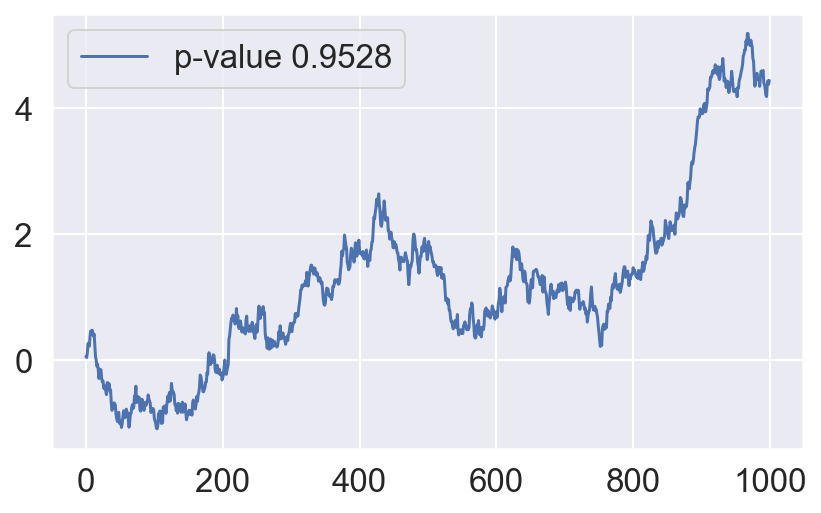

In [16]:
np.random.seed(42)
random_walk = pd.Series(data=np.random.normal(loc=0.0025, scale=0.1, size=1000).cumsum())
plt.plot(random_walk,label='p-value %.4f'%adfuller(random_walk)[1])
plt.legend()
plt.show()

# Stationary and non-Stationary Series
So far, we focused on stationary time series whose statistical properties (such as mean, variance, autocorrelation, etc.) are all constant over time. Series with a zero trend, constant variance, and constant autocorrelation is stationary (or strong stationary, meaning that the entire distribution of data is time-invariant). We have weak stationarity when mean, variance and autocorrelation are time-invariant.

Autocorrelation is time-invariant when $Corr(x_t, x_{t+k})$ is only a function of $k$.

If the process is non-stationary it means that the parameters are different in each point in time that we must estimate and the number of parameters might even become higher of the number of data points. We can only focus on parsimonious models with a limited number of parameters.

Random walks are not stationary since the variance grows with time. Seasonal series are also non-stationary like for instance the number of searches for the word "diet" on Google between 2012 and 2020.

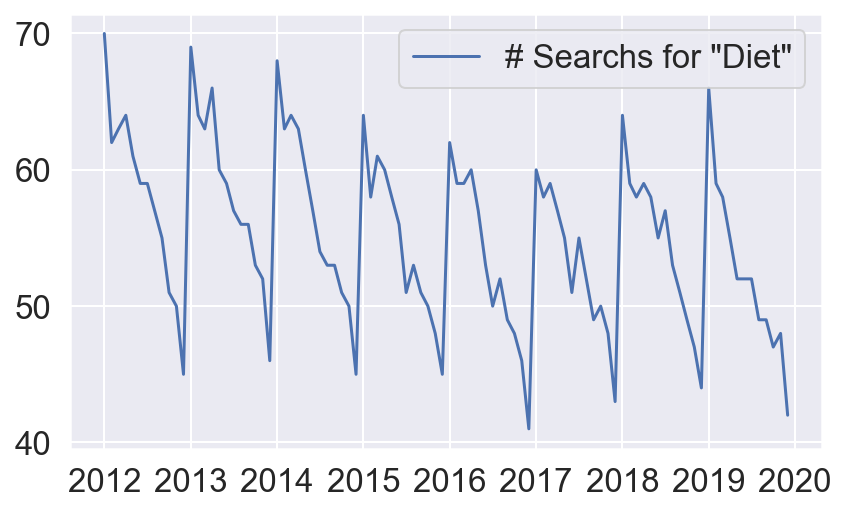

In [17]:
plt.plot(google_diet['2012-1-1':'2019-12-31'],label='# Searchs for "Diet"');
plt.legend();

Non-stationary series can be transformed into stationary ones through simple functions like *diff* for example. So a random walk is non stationary but its diff is stationary. The same if we consider the difference in the search of diet on google taking a lag of 12.

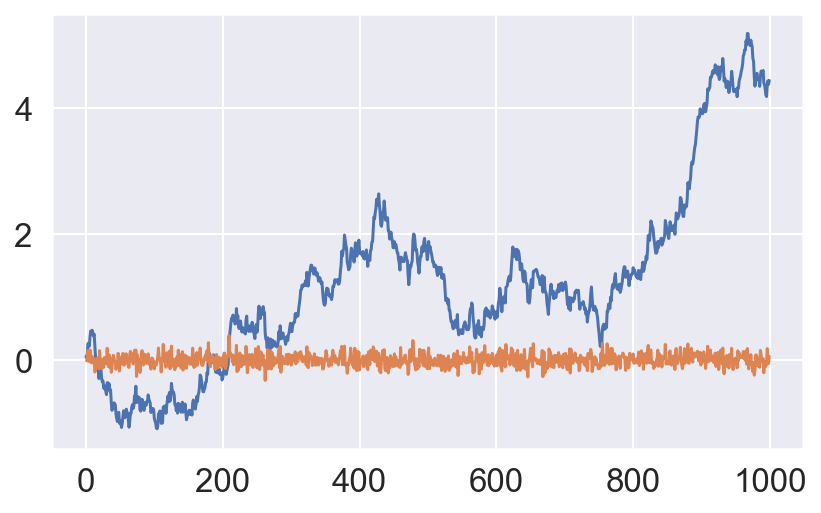

In [18]:
plt.plot(random_walk, label="Random Walk");
plt.plot(random_walk.diff(), label="First Differences");

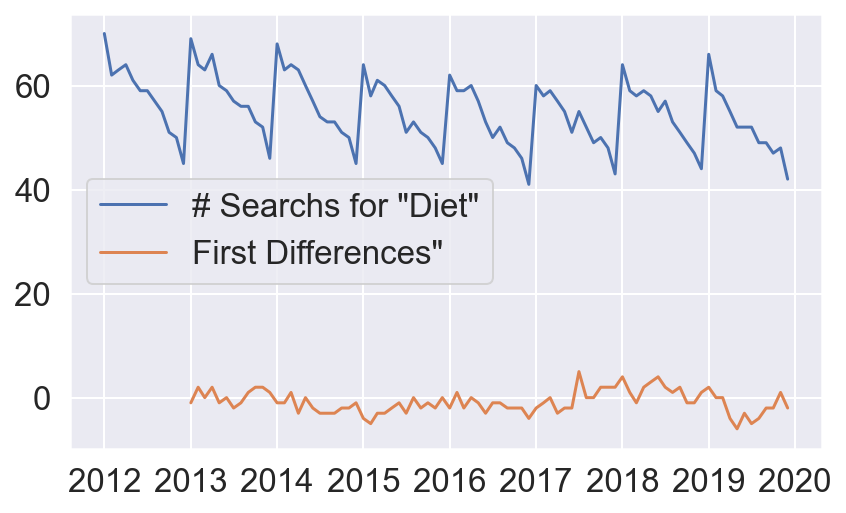

In [19]:
plt.plot(google_diet['2012-1-1':'2019-12-31'],label='# Searchs for "Diet"');
plt.plot(google_diet['2012-1-1':'2019-12-31'].diff(12),label='First Differences"');
plt.legend();

More complex non-stationary series can be transformed into stationary by applying more steps. For instance, the AMZN quaterly revenues are clearly not stationary: it grows exponentially and has shows a seasonal pattern. However, we can first apply a logarithmic transformation (to remove exponential growth) and then the first differences with lag 4 to make the serie stationary.

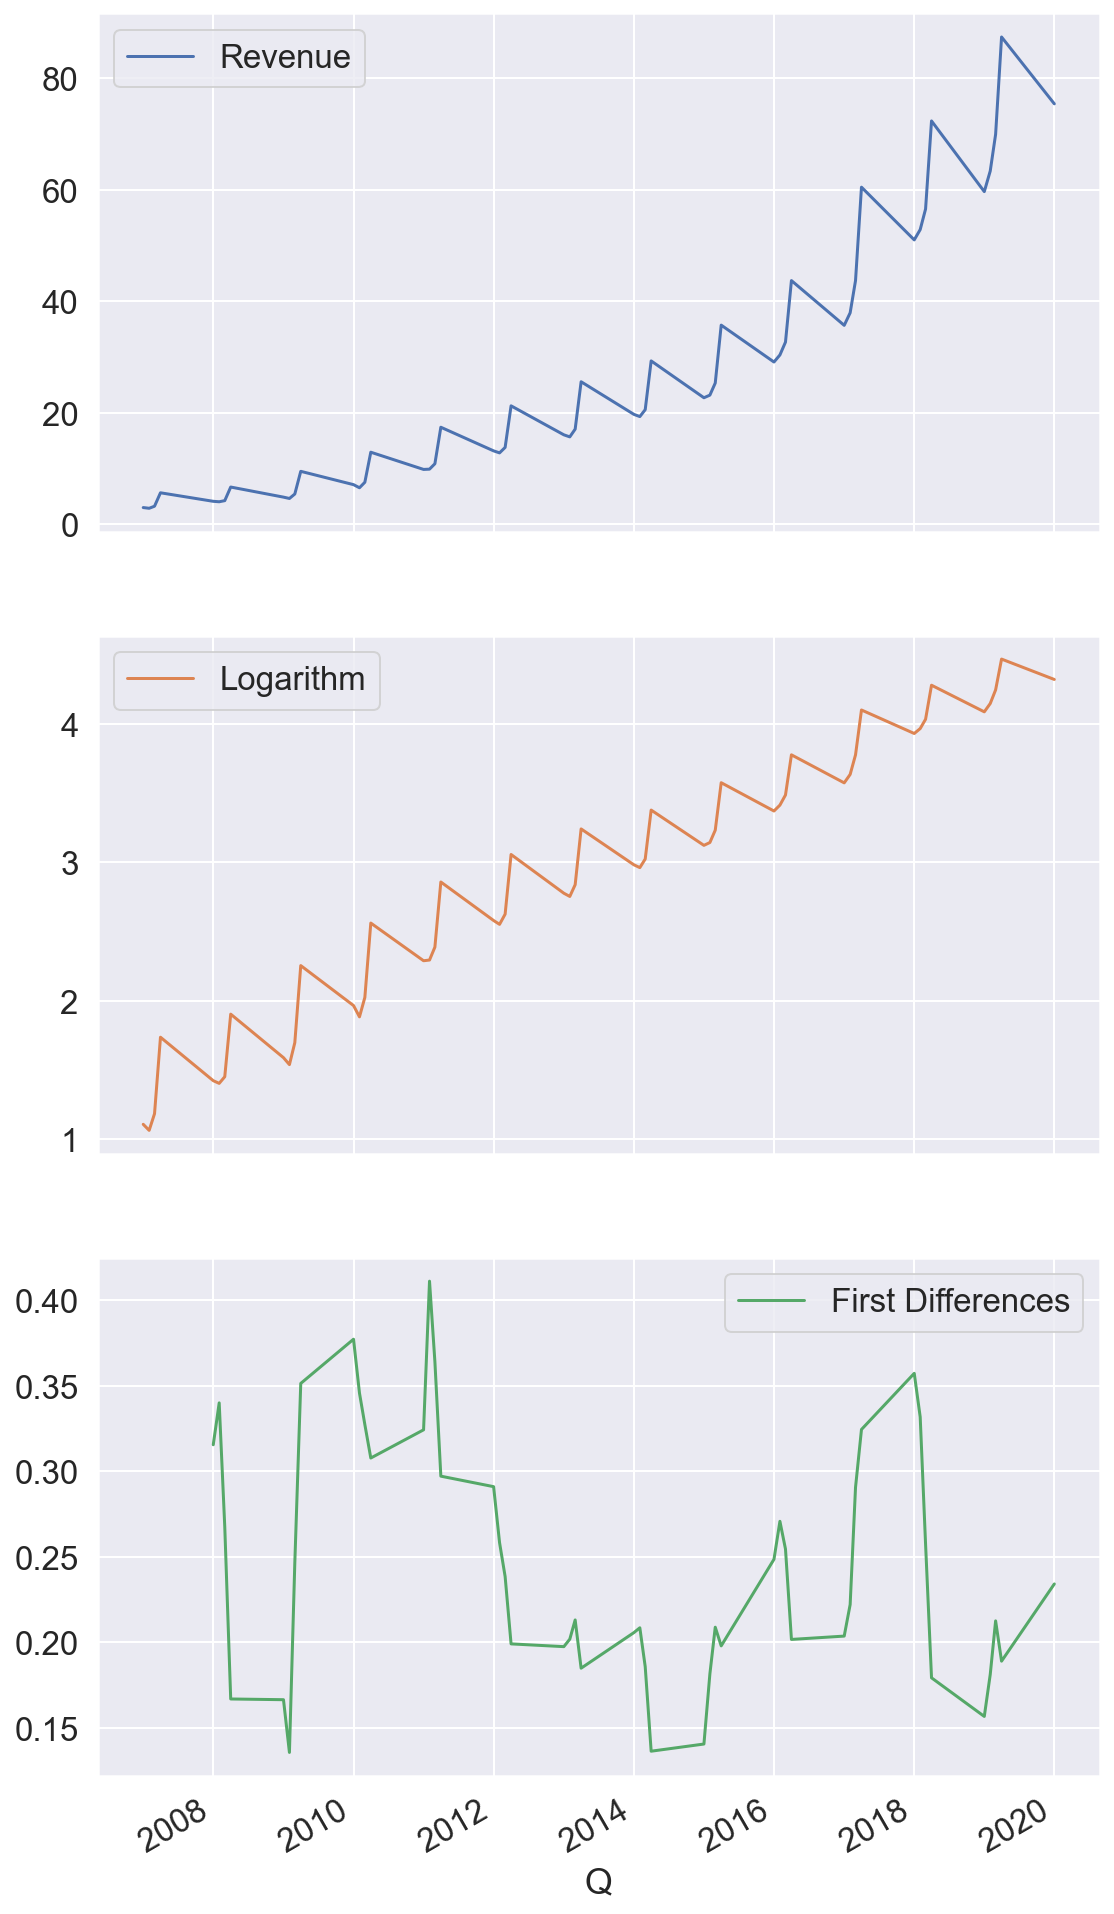

In [20]:
amazon_revenues['Logarithm'] = np.log(amazon_revenues['Revenue'])
amazon_revenues['First Differences'] = amazon_revenues['Logarithm'].diff(4)
amazon_revenues.plot(subplots=True, figsize=(8,18));

To check whether a series is stationary, we can apply the Augmented Dickey fuller test.

In [21]:
adfuller_on_original = adfuller(amazon_revenues['Revenue'])
adfuller_on_log = adfuller(amazon_revenues['Logarithm'])
adfuller_on_fd = adfuller(amazon_revenues['First Differences'].dropna())
print("                      p-value of AMZN revenue: %.4f"%adfuller_on_original[1])
print("                 p-value of Log(AMZN revenue): %.4f"%adfuller_on_log[1])
print("p-value of FirstDifference(Log(AMZN revenue)): %.4f"%adfuller_on_fd[1])

                      p-value of AMZN revenue: 1.0000
                 p-value of Log(AMZN revenue): 0.8033
p-value of FirstDifference(Log(AMZN revenue)): 0.0020


The data about AMZN revenue were stationary (p-value is high we cannot reject the non-stationary hypothesis). However, the final series is stationary (p-value is low and we can reject the non-stationary hypothesis).

Instead of the logarithm, we could have also used the square root of the series, the percentage of change (pct_change), etc.

# AR, MA, ARMA, ARMAX and ARIMA Models

## Autoregressive (AR) Models
An autoregressive (AR) model describes current output value based on a linear combination of its own previous values and a stochastic term (an imperfectly predictable term). In its simplest form, the current value $R_t$ depends solely on the previous value ($R_{t-1}$). This is called an AR model or order 1 or simply AR(1) and it is described by the following equation,

$R_t = \mu + \phi R_{t-1} + \epsilon_t$

so the current value $R_t$ is computed as a mean $\mu$ plus a fraction of the previous value $R_{t-1}$ plus noise $\epsilon_t$ (also called shock term). Note that, 

* if ϕ = 1, the equation models a random walk; 
* if ϕ = 0, the equation models white noise;
* if -1 < ϕ < 1, the equation represents a stationary process

Consider the case of stock market prediction, if $\phi$ is negative, then if yesterday's return were positive, then today's returns are more likely to be negative and viceversa. This behavior is called *mean reversion*. 

In contrast, if $\phi$ is positive, then if yesterday's return were positive, we should expect today's returns to be positive as well. This is called *momentum*.

If we compare model AR(1) with linear regression, $R_t$ is the dependent variable, $R_{t-1}$ is the independent variable, $\phi$ is the slope, and the shock is the residual to the linear model.

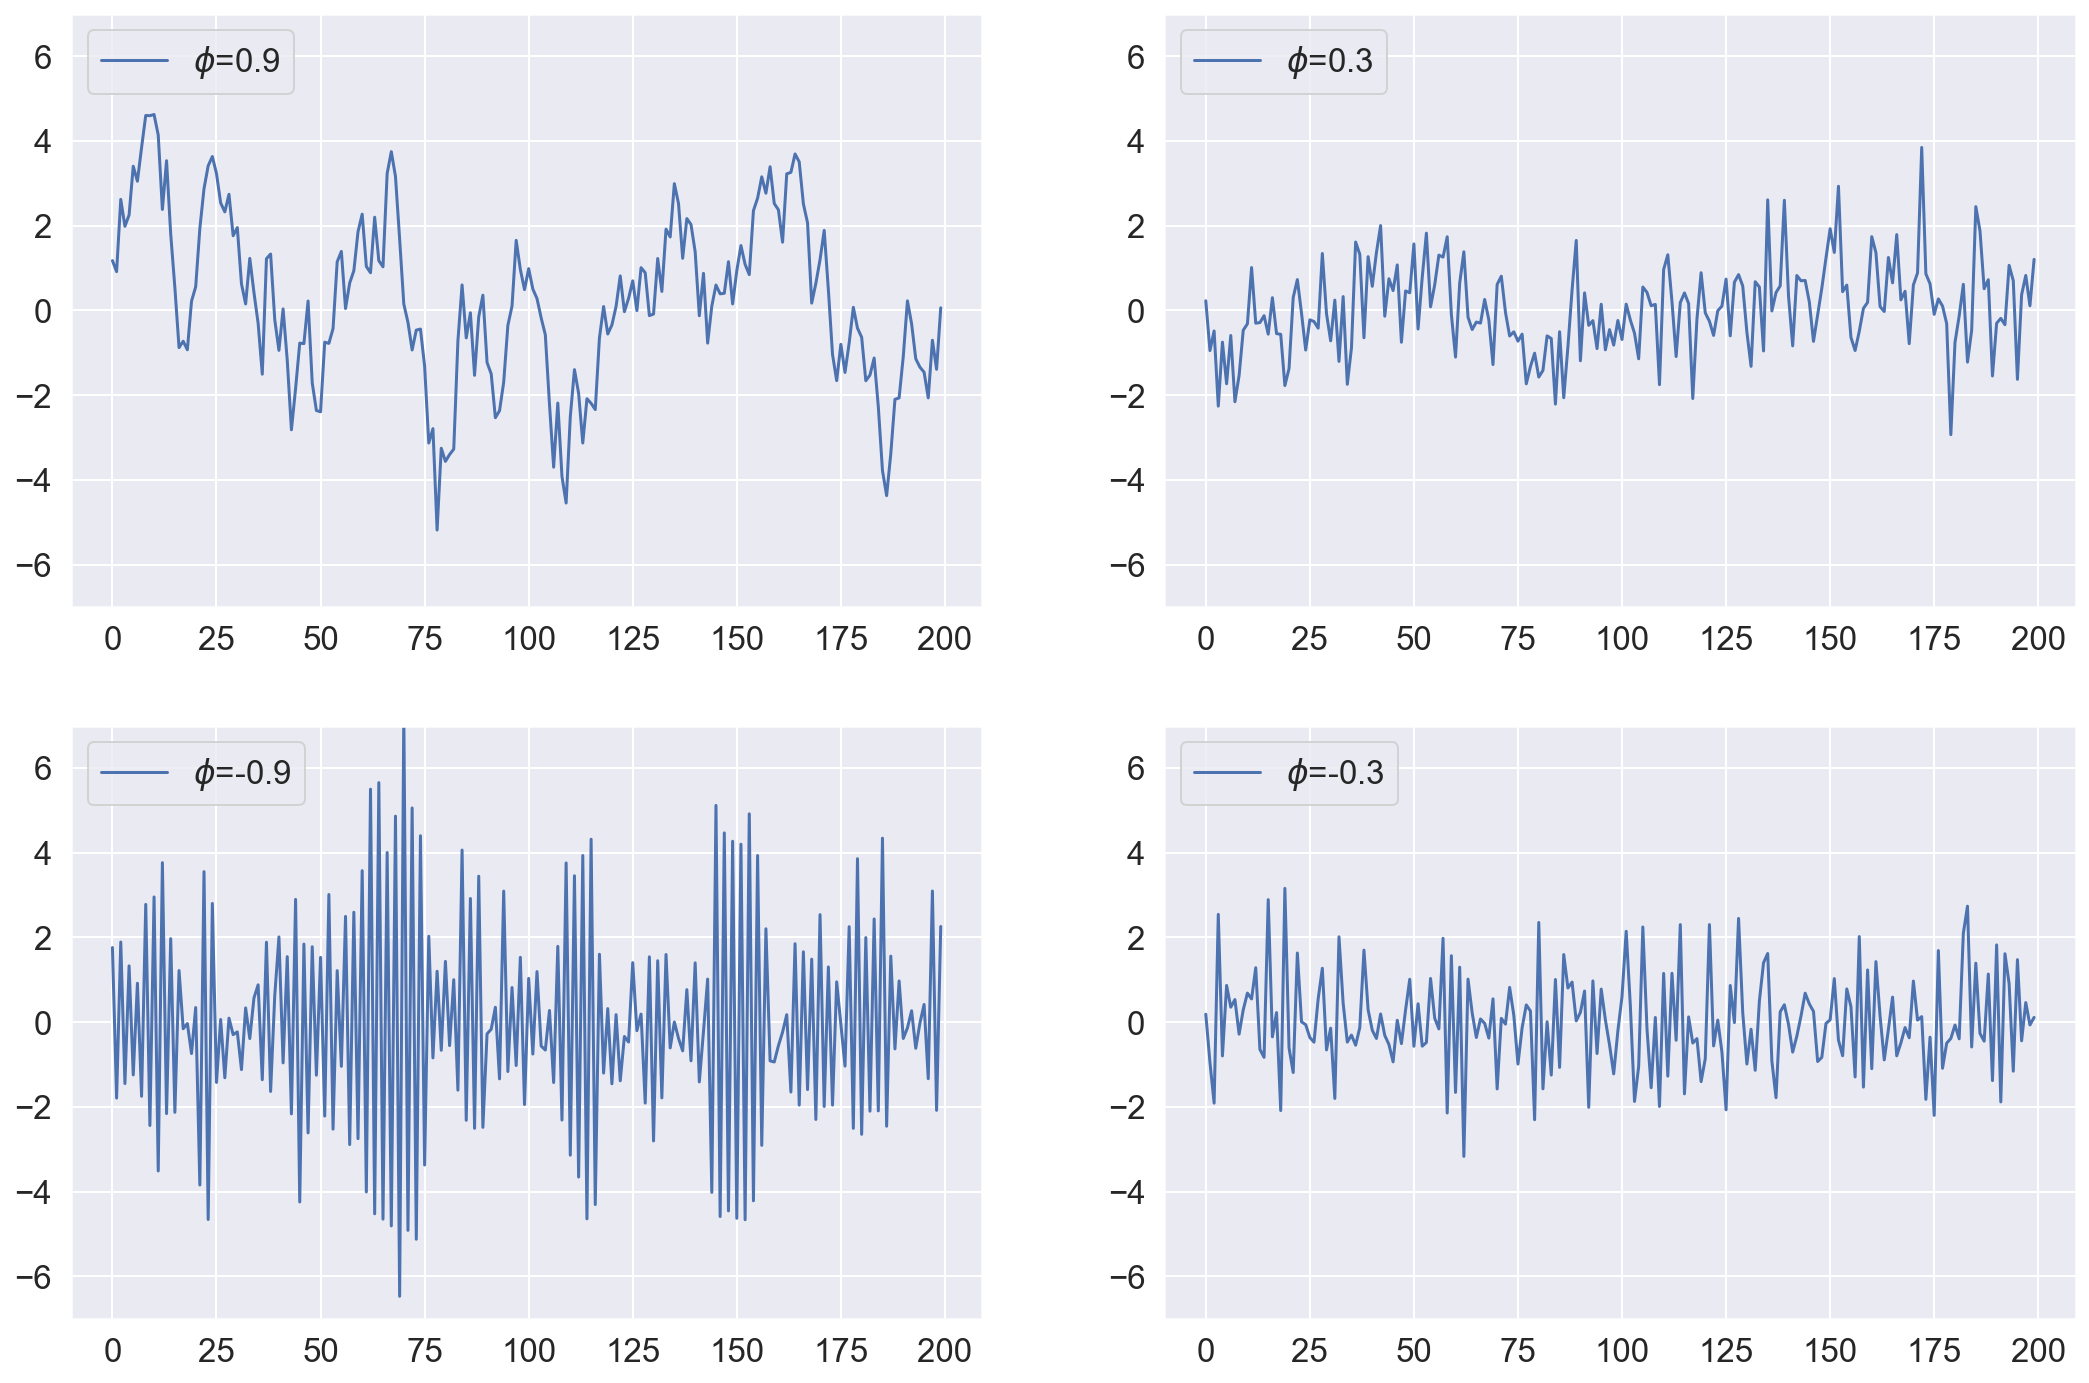

In [22]:
ar1_examples = pd.read_csv('others/ar1_examples.csv')

plt.subplots(2, 2, figsize=(16,12))

plt.subplot(2,2,1)
plt.ylim([-7,7])
plt.plot(ar1_examples['Phi09'],label="$\phi$=0.9")
plt.legend(loc='upper left')

plt.subplot(2,2,3)
plt.ylim([-7,7])
plt.plot(ar1_examples['Phi-09'],label="$\phi$=-0.9")
plt.legend(loc='upper left')

plt.subplot(2,2,2)
plt.ylim([-7,7])
plt.plot(ar1_examples['Phi03'],label="$\phi$=0.3")
plt.legend(loc='upper left')

plt.subplot(2,2,4)
plt.ylim([-7,7])
plt.plot(ar1_examples['Phi-03'],label="$\phi$=-0.3")
plt.legend(loc='upper left')

plt.show()

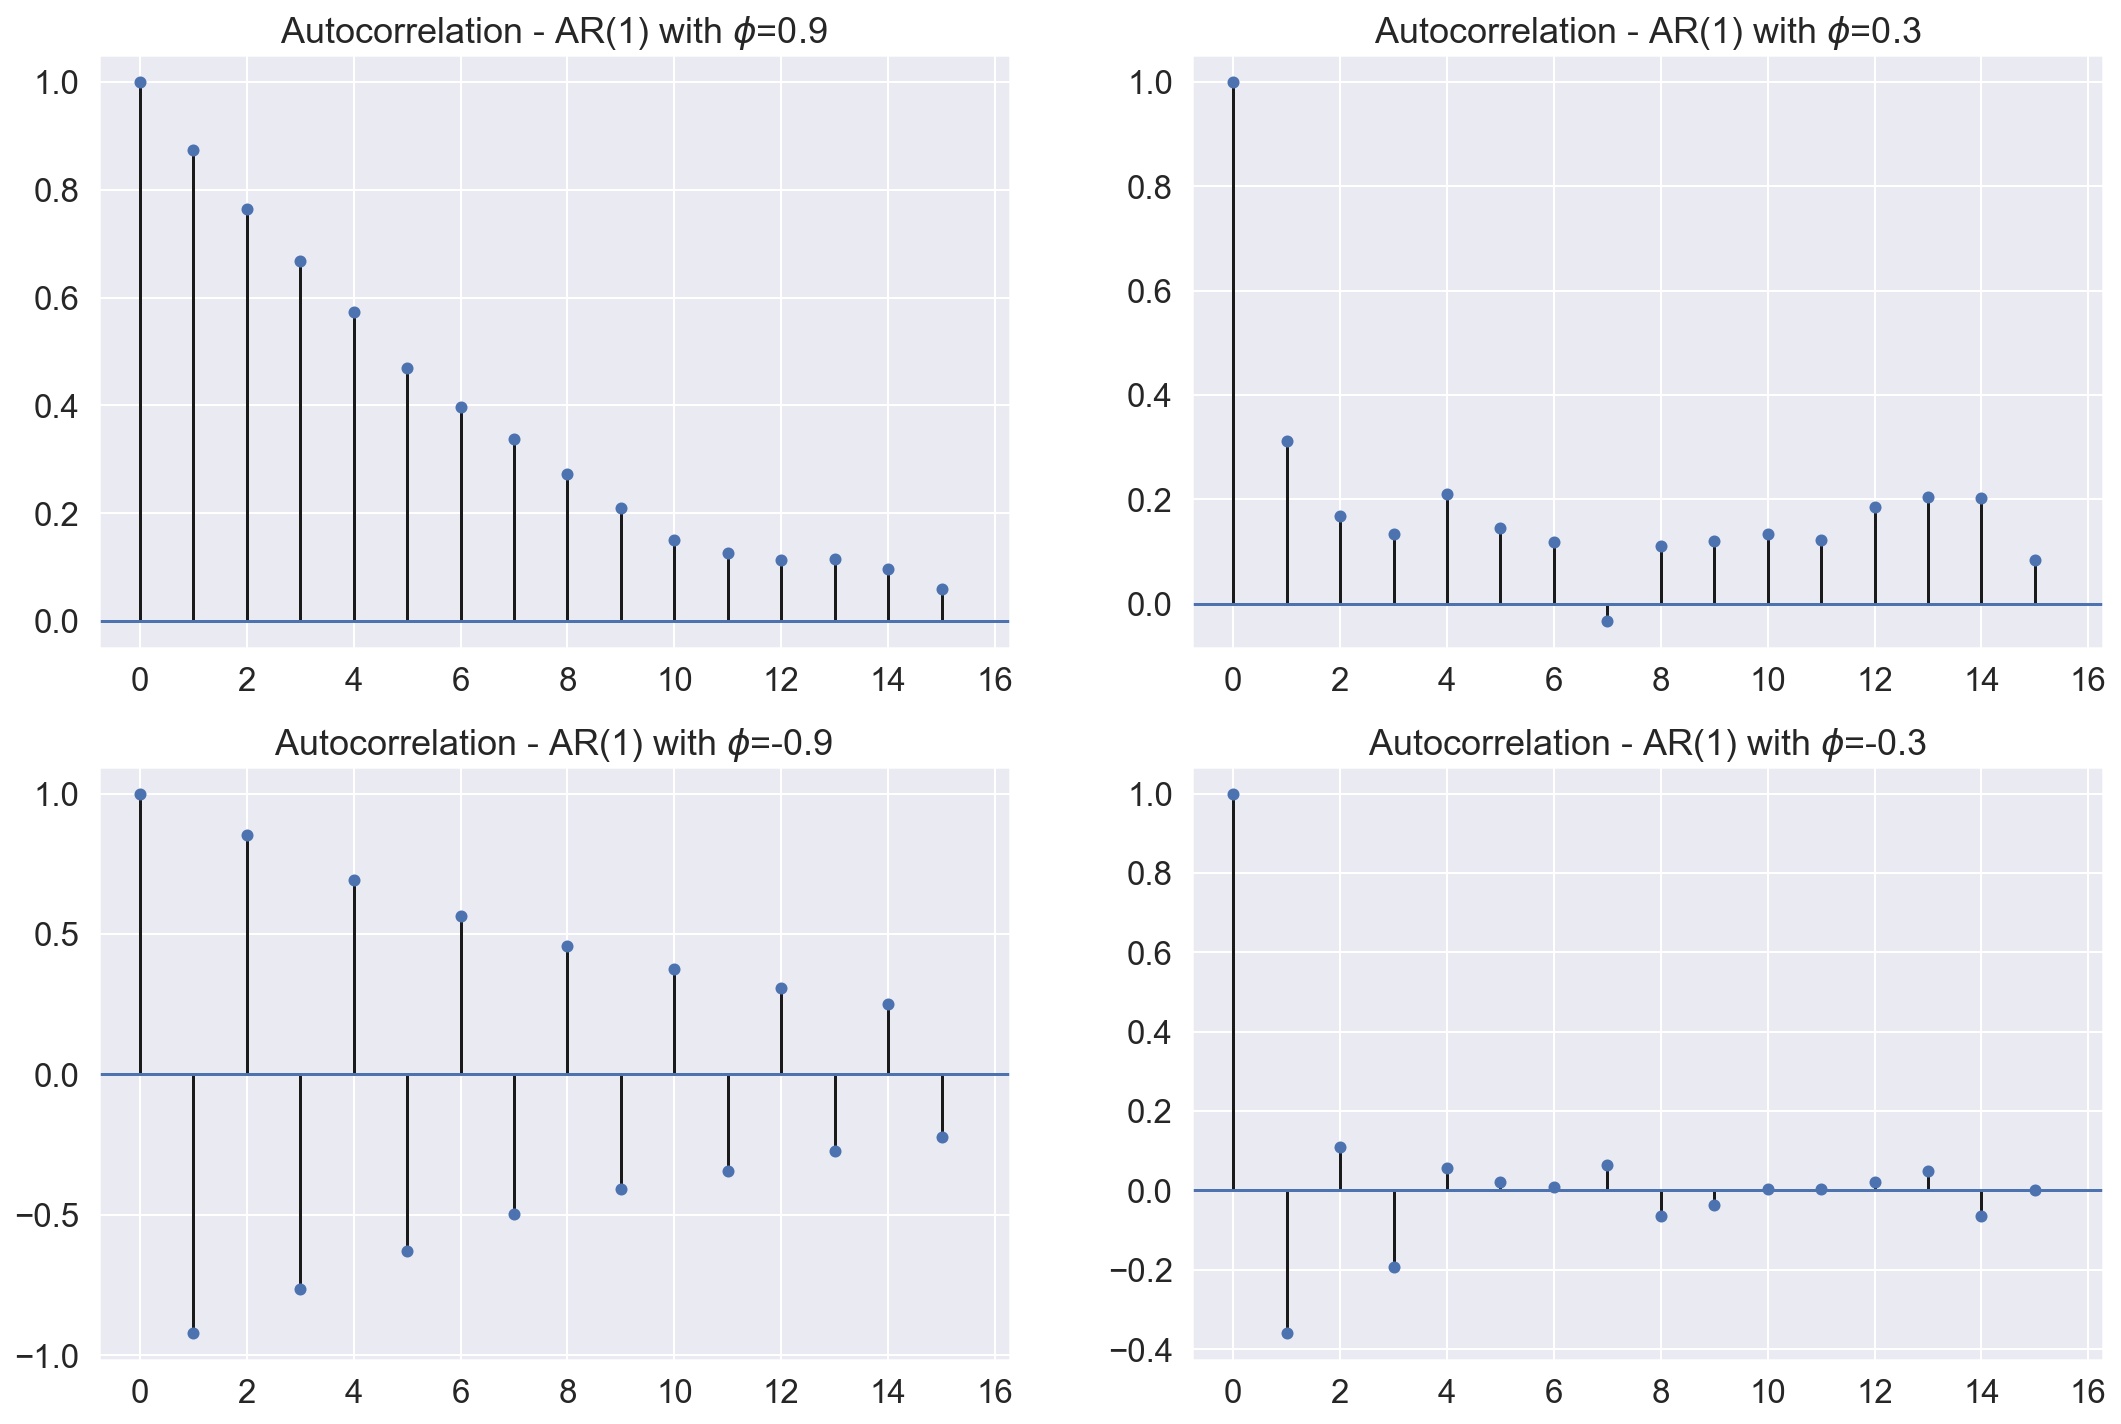

In [23]:
# plt.figure(figsize=(16,12))

fig, ax = plt.subplots(2,2,figsize=(16,12))

ax = plt.subplot(2,2,1)
plot_acf(ar1_examples['Phi09'], alpha=1,lags=15, ax=ax)
ax.set_title("Autocorrelation - AR(1) with $\phi$=0.9")


ax = plt.subplot(2,2,3)
plot_acf(ar1_examples['Phi-09'], alpha=1,lags=15, ax=ax)
ax.set_title("Autocorrelation - AR(1) with $\phi$=-0.9")

ax = plt.subplot(2,2,2)
plot_acf(ar1_examples['Phi03'], alpha=1,lags=15, ax=ax)
ax.set_title("Autocorrelation - AR(1) with $\phi$=0.3")

ax = plt.subplot(2,2,4)
plot_acf(ar1_examples['Phi-03'], alpha=1,lags=15, ax=ax)
ax.set_title("Autocorrelation - AR(1) with $\phi$=-0.3")

plt.show()

 The order of an AR model is the number of lags used. In higher order autoregressive models, current value depends on more of its past values, for instance,
 
 * AR(2) model
 
 R<sub>t</sub> = μ + ϕ<sub>1</sub>R<sub>t-1</sub> + ϕ<sub>2</sub>R<sub>t-2</sub> + ε<sub>t</sub>
 * AR(3) model
 
 R<sub>t</sub> = μ + ϕ<sub>1</sub>R<sub>t-1</sub> + ϕ<sub>2</sub>R<sub>t-2</sub> + ϕ<sub>3</sub>R<sub>t-3</sub> + ε<sub>t</sub>

## Simulating, Fit, and Forecast AR Models
The library statsmodels provides functions to simulate data generated from AR models of a given order, functions to fit data to a model of a given order, and to forecast based on the model.

First, let's simulate an AR(1) with a $\phi$ of 0.8

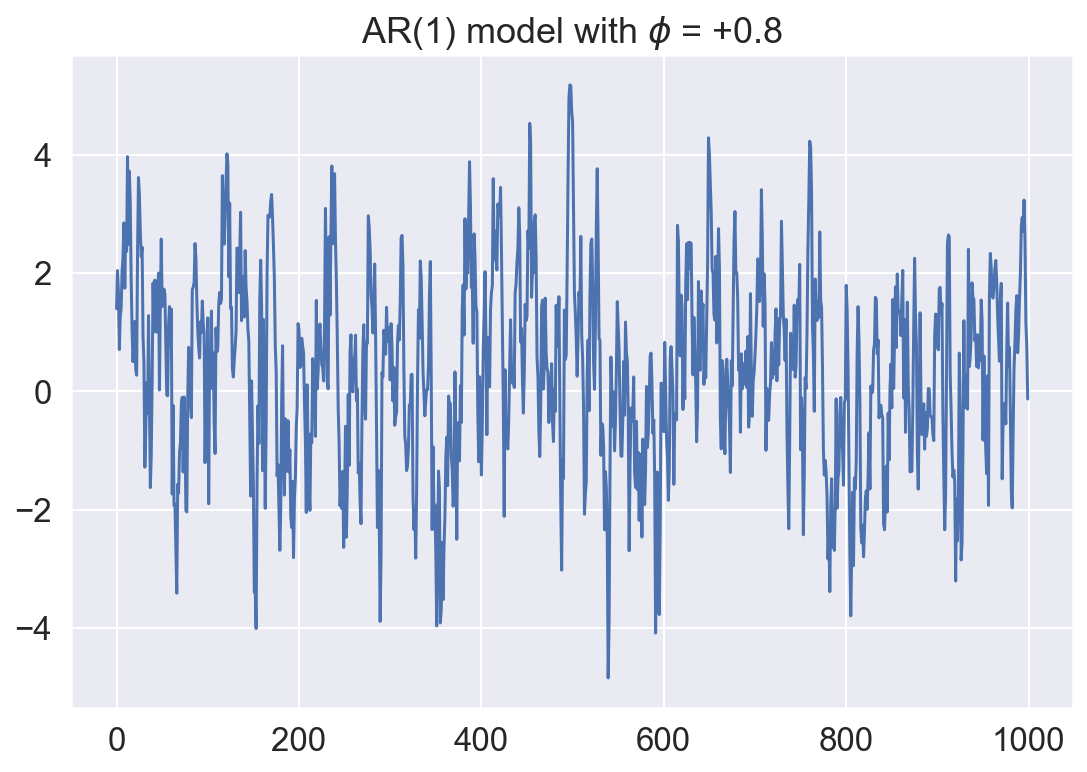

In [24]:
from statsmodels.tsa.arima_process import ArmaProcess

# AR1 with phi = 0.8
ar1 = ArmaProcess(np.array([1, -0.8]), np.array([1]))
simulated_ar1 = ar1.generate_sample(1000)
plt.figure(figsize=(8,6));
plt.plot(simulated_ar1);
plt.title('AR(1) model with $\phi$ = +0.8');

Next, let's fit the data we generated using an AR(1) model.

In [25]:
from statsmodels.tsa.arima_model import ARMA

# simulates an AR(1) model the zero refers to the MA model (see next)
model = ARMA(simulated_ar1, order=(1,0))
result = model.fit()

print(result.summary())
print("μ=%.3f ϕ=%.3f"%(result.params[0],result.params[1]))

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(1, 0)   Log Likelihood               -1415.543
Method:                       css-mle   S.D. of innovations              0.996
Date:                Tue, 17 Nov 2020   AIC                           2837.087
Time:                        19:08:41   BIC                           2851.810
Sample:                             0   HQIC                          2842.683
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3568      0.149      2.401      0.016       0.065       0.648
ar.L1.y        0.7888      0.019     40.713      0.000       0.751       0.827
                                    Roots           

The fitting returns a value of $\phi$ around the actual value we used to generate the data (which was 0.8).

We can finally forecast future values. For values used also during the model building phase, we have a comparison between the actual data and the forecast. For unseen values, we see the prediction and the 95% confidence interval for the prediction.

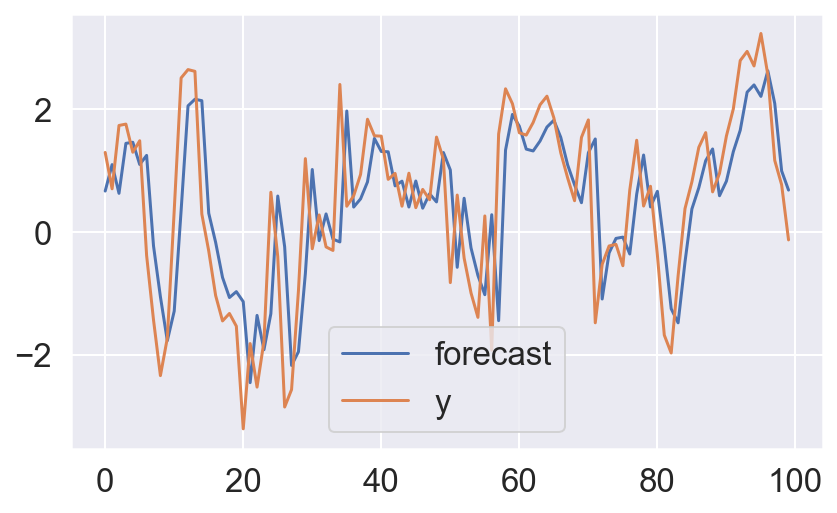

In [26]:
result.plot_predict(start=900)
plt.show()

## Examples with real data
Let's analyze the humidity data for Montreal.

In [27]:
# load the data
humidity = pd.read_csv('weather/humidity.csv', index_col='datetime', parse_dates=['datetime'])

# first row is completely NaN so eliminate it
humidity = humidity.iloc[1:]

# fill unknown values with the previous known value
humidity = humidity.fillna(method='ffill')

humidity.tail()

Vancouver  Portland  San Francisco  Seattle  Los Angeles  \
datetime                                                                        
2017-11-29 20:00:00       87.0      81.0           22.0     93.0         24.0   
2017-11-29 21:00:00       87.0      71.0           22.0     87.0         21.0   
2017-11-29 22:00:00       87.0      71.0           22.0     93.0         23.0   
2017-11-29 23:00:00       87.0      71.0           22.0     87.0         14.0   
2017-11-30 00:00:00       87.0      76.0           22.0     75.0         56.0   

                     San Diego  Las Vegas  Phoenix  Albuquerque  Denver  ...  \
datetime                                                                 ...   
2017-11-29 20:00:00       72.0       18.0     68.0         37.0    18.0  ...   
2017-11-29 21:00:00       72.0       18.0     73.0         34.0    12.0  ...   
2017-11-29 22:00:00       68.0       17.0     60.0         32.0    15.0  ...   
2017-11-29 23:00:00       63.0       17.0     33.0         30.0    28.0  ...   
2017-11-30 00:00:00       72.0       17.0     23.0         34.0    31.0  ...   

                     Philadelphia  New York  Montreal  Boston  Beersheba  \
datetime                                                                   
2017-11-29 20:00:00          27.0      58.0      64.0    37.0       57.0   
2017-11-29 21:00:00          29.0      58.0      59.0    74.0       57.0   
2017-11-29 22:00:00          31.0      58.0      66.0    74.0       57.0   
2017-11-29 23:00:00          26.0      58.0      58.0    56.0       57.0   
2017-11-30 00:00:00          32.0      58.0      58.0    56.0       57.0   

                     Tel Aviv District  Eilat  Haifa  Nahariyya  Jerusalem  
datetime                                                                    
2017-11-29 20:00:00               60.0  100.0   96.0       96.0       60.0  
2017-11-29 21:00:00               60.0  100.0   96.0       96.0       60.0  
2017-11-29 22:00:00               60.0  100.0   96.0       96.0       60.0  
2017-11-29 23:00:00               60.0  100.0   96.0       96.0       60.0  
2017-11-30 00:00:00               60.0  100.0   96.0       96.0       60.0  

[5 rows x 36 columns]

Now let's fit the data of the humidity in Montreal using first differences data and an AR(1)

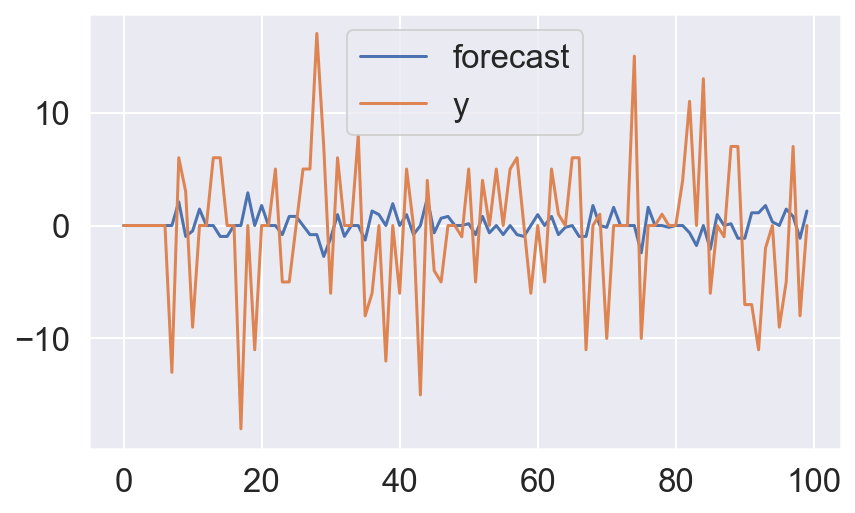

In [28]:
montreal_model = ARMA(humidity["Montreal"].diff().iloc[1:].values, order=(1,0))
montreal_result = montreal_model.fit()
montreal_result.plot_predict(start=-100)
plt.show()

Not quite impressive. We can evaluate our prediction using root mean square error (RMSE),

In [29]:
rmse = math.sqrt(mean_squared_error(humidity["Montreal"].diff().iloc[900:1000].values, result.predict(start=900,end=999)))
print("The root mean squared error is %.3f"%rmse)

The root mean squared error is 7.008


Even if we try Google stock close price, the results are not impressive. There are better models though.

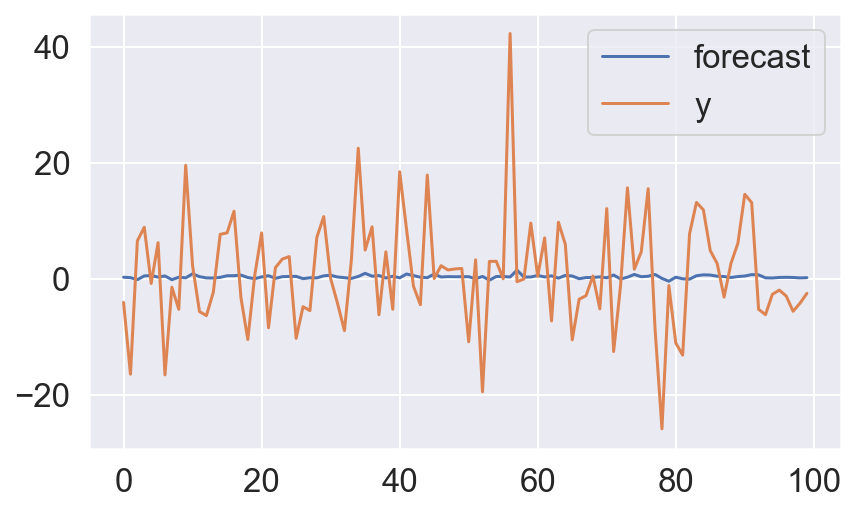

In [30]:
google_model = ARMA(google["Close"].diff().iloc[1:].values, order=(1,0))
google_result = google_model.fit()
google_result.plot_predict(start=-100)
plt.show()

There are always better models.

## Moving Average Models

The moving-average (MA) model specifies that the output variable depends linearly on the current and various past values of a stochastic (imperfectly predictable) term. The moving-average model of order 1 is defined as,

R<sub>t</sub> = μ  +  ϵ<sub>t</sub> + θϵ<sub>t-1</sub>

Thus it models today returns as a mean plus today noise and yesterday noise. Since there is only one lagged noise value, the model is of order 1. Moving average models regress the value of the time series against the previous shock (white noise) values of the same time series and the current shock.

What we discussed for AR models can be applied to MA model so we can simulate a model, we can fit it and we can forecast future values.

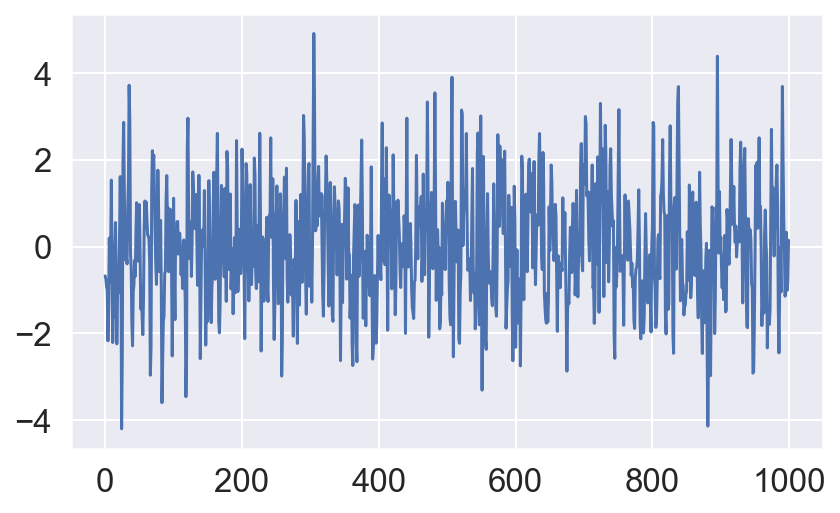

In [31]:
# simulate an MA(1) with theta of 0.5

# no AR component
ar1 = np.array([1])

# MA of order 1 with theta of 0.5
ma1 = np.array([1, 0.9])

# Generate and plot the data
ma1 = ArmaProcess(ar1, ma1)
simulated_ma1 = ma1.generate_sample(nsample=1000)
plt.plot(simulated_ma1);

In [32]:
# Create a MA(1)
ma1_model = ARMA(simulated_ma1, order=(0,1))

# fit the model
ma1_result = ma1_model.fit()

# print the parameters
print(result.summary())

print("μ=%.3f θ=%.3f"%(ma1_result.params[0],ma1_result.params[1]))

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(1, 0)   Log Likelihood               -1415.543
Method:                       css-mle   S.D. of innovations              0.996
Date:                Tue, 17 Nov 2020   AIC                           2837.087
Time:                        19:08:54   BIC                           2851.810
Sample:                             0   HQIC                          2842.683
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3568      0.149      2.401      0.016       0.065       0.648
ar.L1.y        0.7888      0.019     40.713      0.000       0.751       0.827
                                    Roots           

As before, $\theta$ is very similar to the value used in the simulation. 

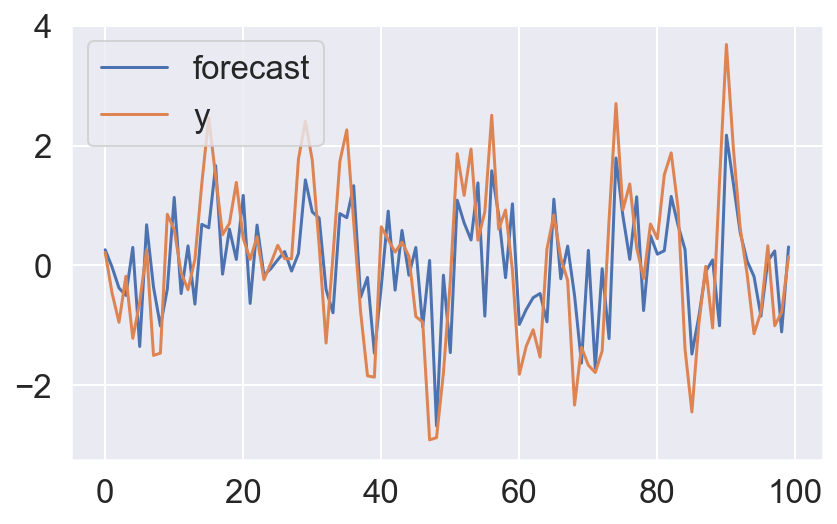

In [33]:
g = ma1_result.plot_predict(start=-100)

## ARMA models
Autoregressive–moving-average (ARMA) models combine AR and MA models. They provide a parsimonious description of a (weakly) stationary stochastic process in terms of two polynomials, one for the autoregression and one for the moving average. They are described by the order or the AR model and the order of the MA model. For example, an ARMA(1,1) is defined as, 

R<sub>t</sub> = μ + ϕR<sub>t-1</sub> + ϵ<sub>t</sub> + θϵ<sub>t-1</sub> 

Basically, it describes today's return as the sum of a mean, yesterday return, a today noise, and yesterday noise.

ARMA models are identified as ARMA(p,q) where p is the order of the autoregressive part while q is the order of the moving average part.

Simulating ARMA model is very similar to what we previously did with AR and MA models. Also the functions used to fit and forecast are basically the same. Let's apply ARMA to model Microsoft volume first difference data using an ARMA(3,2).

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3018
Model:                     ARMA(3, 2)   Log Likelihood              -55409.783
Method:                       css-mle   S.D. of innovations       22757678.111
Date:                Tue, 17 Nov 2020   AIC                         110833.567
Time:                        19:08:59   BIC                         110875.653
Sample:                             0   HQIC                        110848.701
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -2.03e+04   9816.616     -2.068      0.039   -3.95e+04   -1057.007
ar.L1.y        1.0773      0.090     11.972      0.000       0.901       1.254
ar.L2.y       -0.1878      0.041     -4.607      0.0

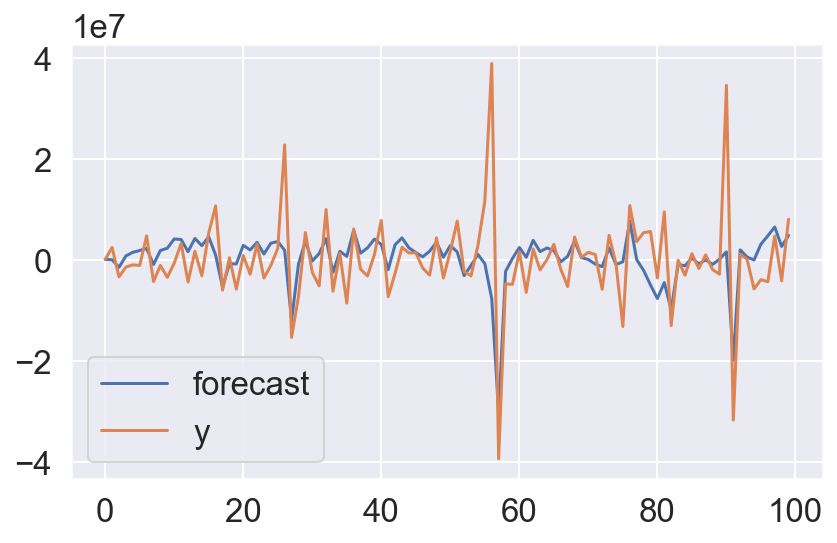

In [34]:
microsoft_model = ARMA(microsoft["Volume"].diff().iloc[1:].values, order=(3,2))
microsoft_result = microsoft_model.fit()
print(microsoft_result.summary())
print("μ=%.3f, ϕ1=%.3f, θ1=%.3f"%(microsoft_result.params[0],microsoft_result.params[1],microsoft_result.params[2]))
microsoft_result.plot_predict(start=-100)
plt.show()

*S.D. of innovations* is the standard deviation associated with the shock terms. *const* is the $\mu$ parameter; *ar.L1.y*, *ar.L2.y*, *ar.L3.y*, *ma.L1.y*, and *ma.L2.y* are the AR/MA model parameters for each lag $L$. *std err* shows the standard error associated with each parameter and next you have the confidence interval.

In [35]:
rmse = math.sqrt(mean_squared_error(microsoft["Volume"].diff().iloc[1000:1101].values, microsoft_result.predict(start=1000,end=1100)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 38017620.15944339.


## ARMAX Models
ARMAX models extend ARMA models by adding exogenous inputs to the model. Thus, we model the time series combining the time series itself with other independent variables. ARMAX is like a combination of an ARMA model with a linear regression model. 

* ARMA(1,1) $R_t = \mu + \phi R_{t-1} + \epsilon_t + \theta \epsilon_{t-1}$
* ARMA(1,1) $R_t = \mu + \phi R_{t-1} + \epsilon_t + \theta \epsilon_{t-1} + \eta d_{t-1}$

Where $d_{t-1}$ is an endogenous variable which represents extra information that can help the prediction of the series. For example, if we are predicting the power consumption of our home, it might be useful to add the outside temperature since if in very hot days, we might turn the airconditioning on an use more electricity. Let's fit an ARMAX model to predict the waiting time in a hospital using the number of nurses in service as the exogenous variable.

In [36]:
hospital = pd.read_csv('others/hospital.csv',index_col='date', parse_dates=['date'])
hospital.head()

wait_times_hrs  nurse_count
date                                            
2019-03-04 00:00:00        1.747261          1.0
2019-03-04 01:00:00        1.664634          1.0
2019-03-04 02:00:00        1.647047          1.0
2019-03-04 03:00:00        1.619512          1.0
2019-03-04 04:00:00        1.480415          1.0

In [37]:
hospital_model = ARMA(hospital['wait_times_hrs'], order=(2,1),exog=hospital['nurse_count'])
hospital_results = hospital_model.fit()
hospital_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:         wait_times_hrs   No. Observations:                  168
Model:                     ARMA(2, 1)   Log Likelihood                 -11.834
Method:                       css-mle   S.D. of innovations              0.259
Date:                Tue, 17 Nov 2020   AIC                             35.667
Time:                        19:09:02   BIC                             54.411
Sample:                    03-04-2019   HQIC                            43.275
                         - 03-10-2019                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.1000      0.086     24.293      0.000       1.931       2.269
nurse_count             -0.1171      0.013     -9.054      0.000      -0.142      -0.092
ar.L1.wait_times_hrs     0.5693      0.164      3.468      0.001       0.248       0.891
ar.L2.wait_times_hrs    -0.1612      0.131     -1.226      0.220      -0.419       0.096
ma.L1.wait_times_hrs     0.3728      0.157      2.375      0.018       0.065       0.680
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7656           -1.7566j            2.4906           -0.1246
AR.2            1.7656           +1.7566j            2.4906            0.1246
MA.1           -2.6827           +0.0000j            2.6827            0.5000
-----------------------------------------------------------------------------
"""

In addition to the usual lagged variables (ar.L1, ar.L2 and ma.L1) the summary also provides the statistica for the exogenous variable *nurse_count*.

## ARIMA models
ARMA models cannot be applied to non-stationary time-series. To apply ARMA to a non-stationary series we would have to,
* Take the difference of the original non-stationary time-series to make it stationary
* Fit the ARMA model
* Transform the result to map the model of the differences to a forecast over the actual data

AutoRegressive Integrated Moving Average (ARIMA) models tackle the modeling of non-stationary time series and can be viewed as an extension to ARMA that performs the above steps for us. ARIMA is applied in some cases when data appears to be non-stationarity and an initial differencing step (corresponding to the "integrated" part of the model) can be applied one or more times to eliminate the non-stationarity.

ARIMA models are expressed in the form ARIMA(p,d,q) where p is AR parameter, d is differential parameter, q is MA parameter

* ARIMA(1,0,0) y<sub>t</sub> = a<sub>1</sub>y<sub>t-1</sub> + ϵ<sub>t</sub>
* ARIMA(1,0,1) y<sub>t</sub> = a<sub>1</sub>y<sub>t-1</sub> + ϵ<sub>t</sub> + b<sub>1</sub>ϵ<sub>t-1</sub>
* ARIMA(1,1,1) Δy<sub>t</sub> = a<sub>1</sub>Δy<sub>t-1</sub> + ϵ<sub>t</sub> + b<sub>1</sub>ϵ<sub>t-1</sub> where Δy<sub>t</sub> = y<sub>t</sub> - y<sub>t-1</sub>

As an example, let's consider the closing price of Amazon stocks. We apply Advanced Dickey-Fuller tests to check whether the series it is stationary. 

In [38]:
adf = adfuller(amazon["Close"])
print("p-value of Amazon closing price: %.4f"%adf[1])

adf = adfuller(amazon["Close"].diff(1).dropna())
print("p-value of Amazon first difference closing price: %.4f"%adf[1])

p-value of Amazon closing price: 1.0000
p-value of Amazon closing price: 0.0000


Since the p-value for the original data is 1, we cannot reject the null hypothesis that the series is a random walk. In contrast, the p-value for the first difference is 0.0 so we can reject the null hypothesis. 

In [39]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
amazon_arima_model = SARIMAX(amazon["Close"],order=(2,1,2))
amazon_results = amazon_arima_model.fit()
amazon_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 3019
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -10058.813
Date:                Tue, 17 Nov 2020   AIC                          20127.627
Time:                        19:09:10   BIC                          20157.688
Sample:                             0   HQIC                         20138.436
                               - 3019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1459      0.142      8.041      0.000       0.867       1.425
ar.L2         -0.5551      0.149     -3.728      0.000      -0.847      -0.263
ma.L1         -1.1207      0.146     -7.691      0.000      -1.406      -0.835
ma.L2          0.5071      0.154      3.287      0.001       0.205       0.809
sigma2        45.9671      0.249    184.260      0.000      45.478      46.456
===================================================================================
Ljung-Box (Q):                       83.32   Jarque-Bera (JB):            355071.09
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              22.52   Skew:                             2.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        55.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [40]:
amazon_prediction = amazon_results.get_prediction(start=-200)
amazon_mean_prediction = amazon_prediction.predicted_mean
confidence_intervals = amazon_prediction.conf_int()
lower_limits = confidence_intervals['lower Close']
upper_limits = confidence_intervals['upper Close']

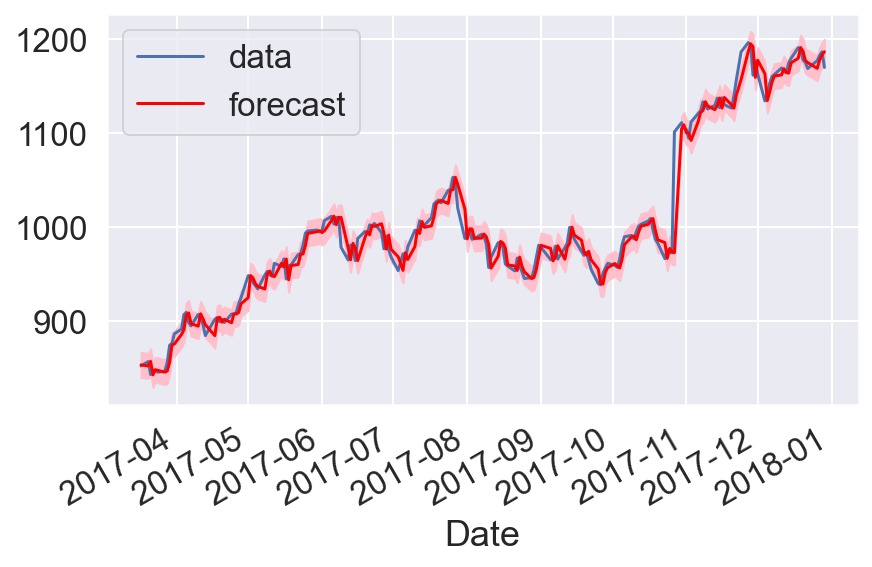

In [41]:
plt.figure()
# Plot prediction
plt.plot(amazon["Close"][-200:],label='data')
amazon_mean_prediction.plot(color='red', label='forecast')
# plt.plot(amazon_mean_prediction.index, amazon_mean_prediction, color='red', label='forecast')
plt.fill_between(amazon_mean_prediction.index, lower_limits,upper_limits, color='pink')
plt.legend()
plt.show()

An autoregressive integrated moving average (ARIMA) model is a generalization of an autoregressive moving average (ARMA) model. Both of these models are fitted to time series data either to better understand the data or to predict future points in the series (forecasting). 

## Prediction using ARIMA model

In [42]:
# Predicting the microsoft stocks volume
microsoft_model = SARIMAX(microsoft["Volume"], order=(3,1,2))
microsoft_results = microsoft_model.fit()
microsoft_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Volume   No. Observations:                 3019
Model:               SARIMAX(3, 1, 2)   Log Likelihood              -55414.048
Date:                Tue, 17 Nov 2020   AIC                         110840.096
Time:                        19:09:13   BIC                         110876.170
Sample:                             0   HQIC                        110853.068
                               - 3019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0582      0.078     13.508      0.000       0.905       1.212
ar.L2         -0.1808      0.035     -5.116      0.000      -0.250      -0.112
ar.L3          0.0060      0.022      0.268      0.789      -0.038       0.050
ma.L1         -1.6652      0.078    -21.358      0.000      -1.818      -1.512
ma.L2          0.6684      0.077      8.715      0.000       0.518       0.819
sigma2      5.515e+14   2.39e-16    2.3e+30      0.000    5.51e+14    5.51e+14
===================================================================================
Ljung-Box (Q):                       46.10   Jarque-Bera (JB):           1487231.52
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                             6.61
Prob(H) (two-sided):                  0.00   Kurtosis:                       110.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.15e+45. Standard errors may be unstable.
"""

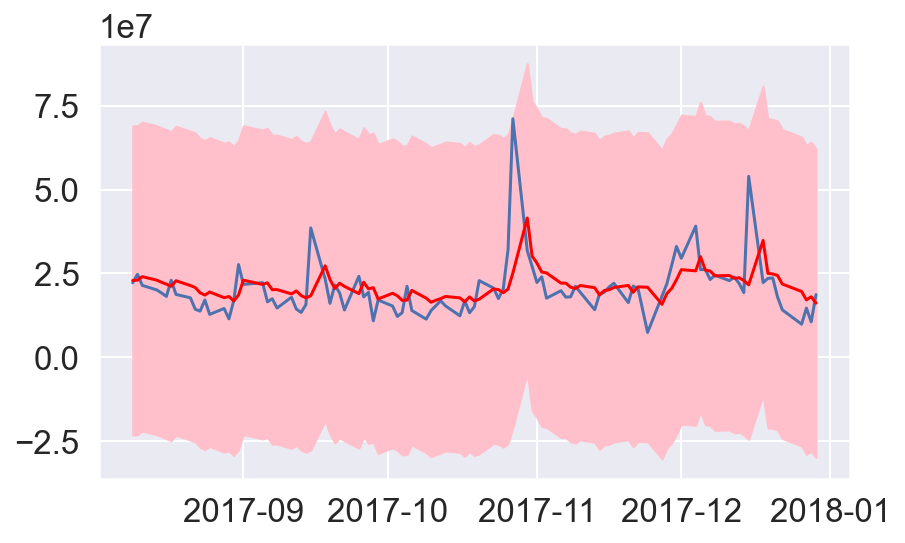

In [43]:
microsoft_forecast = microsoft_results.get_prediction(start=-100)
mean_forecast = microsoft_forecast.predicted_mean
confidence_intervals = microsoft_forecast.conf_int()
lower_limits = confidence_intervals['lower Volume']
upper_limits = confidence_intervals['upper Volume']
plt.plot(microsoft["Volume"][-100:])
# dates = mean_forecast.index
plt.plot(mean_forecast, color='red', label='forecast')
plt.fill_between(lower_limits.index, lower_limits,upper_limits, color='pink')
plt.show()

# Model Diagnostic
At the end, we need to evaluate how good is the final model. For this purpose we need to analyze the residuals with some diagnostic tools. Residuals are computed as the difference between the real value and the predicted value. They should be distributed around zero and should look like unpredictable white noise. Accordingly, their correlogram should have only one peak at zero and everything else should be with the 95% confidence interval. 

As a first example let's consider the data for the waiting times in hospitals that we used earlier. We fit it with an ARMA(2,2) and analyze its residuals.

In [44]:
hospital_model = SARIMAX(hospital['wait_times_hrs'], order=(2,0,2))
hospital_results = hospital_model.fit()

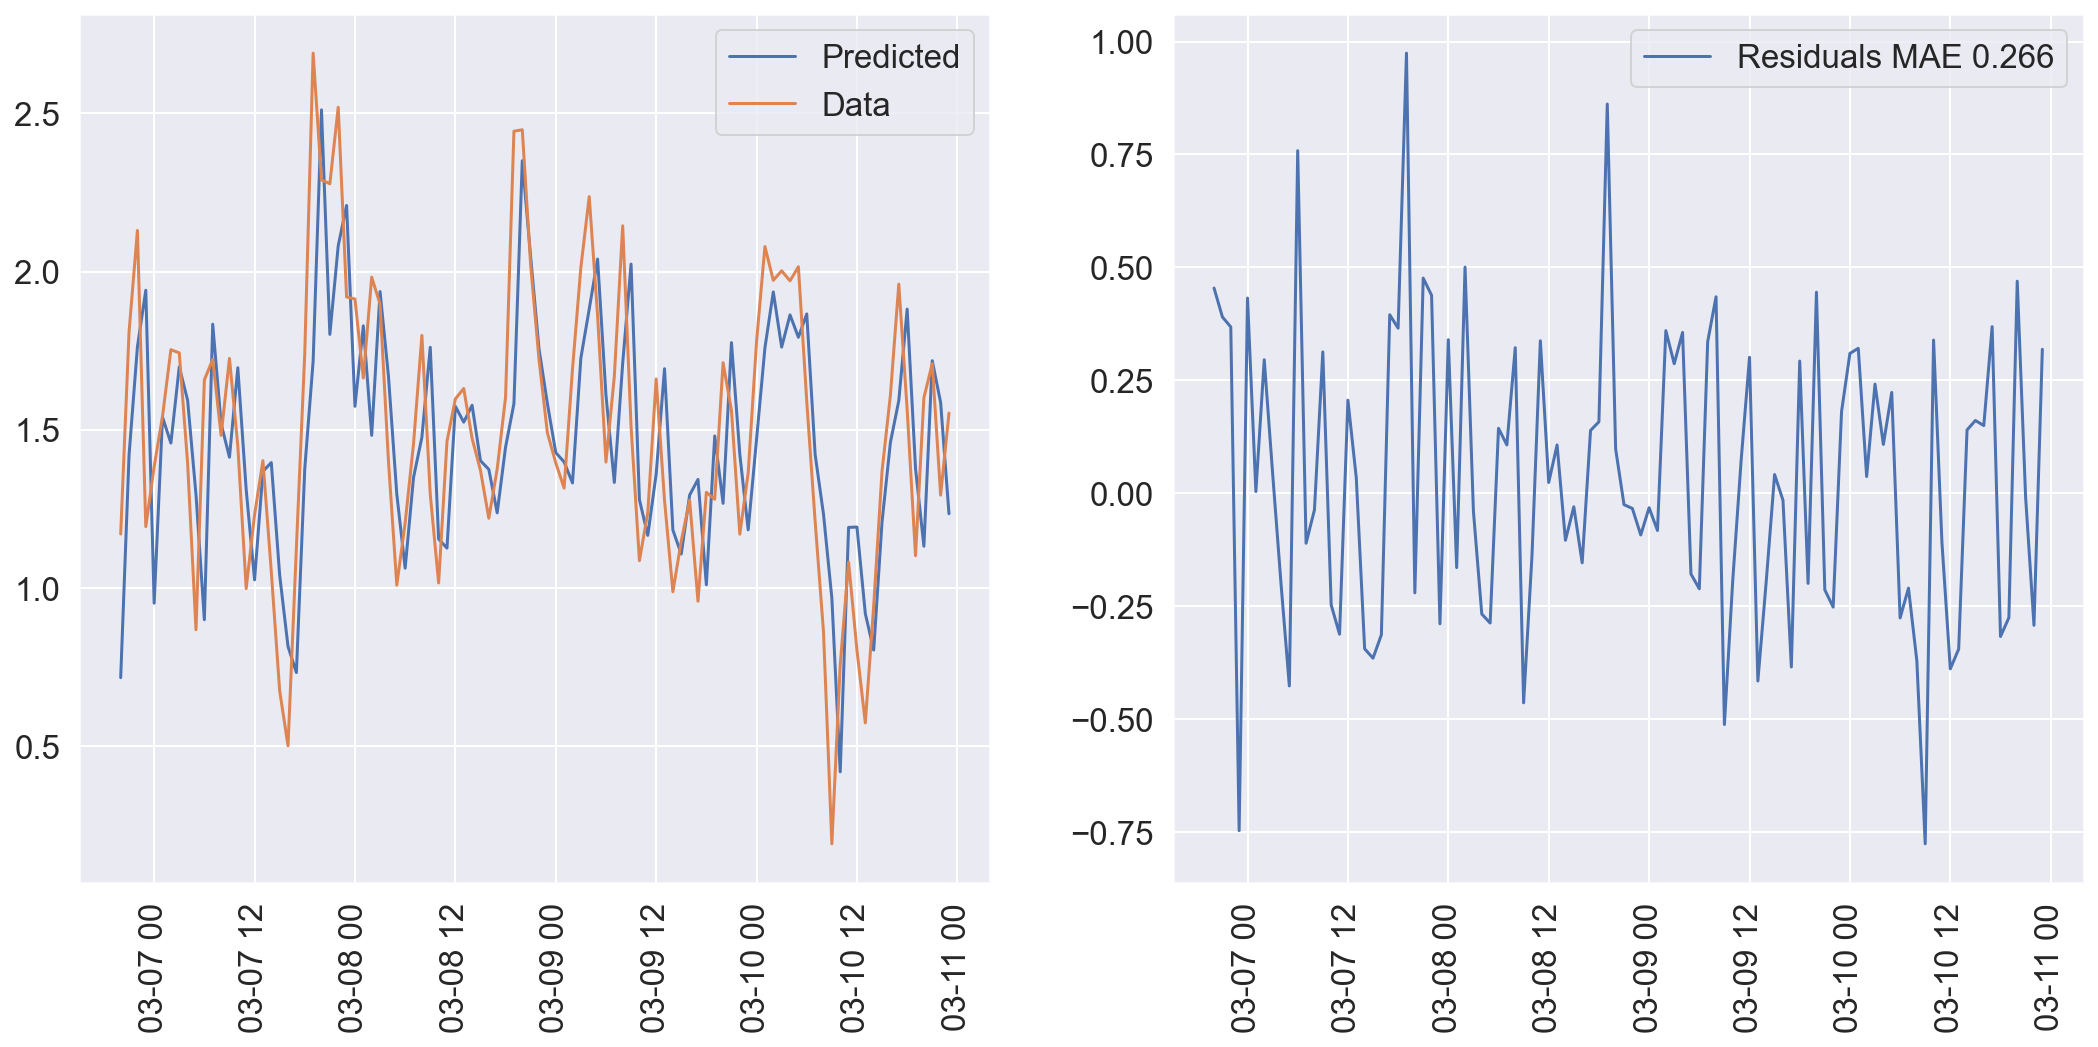

In [45]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(hospital_results.predict()[-100:], label="Predicted");
plt.plot(hospital['wait_times_hrs'][-100:], label="Data");
plt.xticks(rotation=90)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hospital_results.resid[-100:], label="Residuals MAE %.3f"%hospital_results.mae);
plt.xticks(rotation=90)
plt.legend()

Residuals are centered around zero and show no seasonality of particular pattern. But to analyze the model further we can use the function plot_diagnostics that provides four plots to analyze the residuals even further.

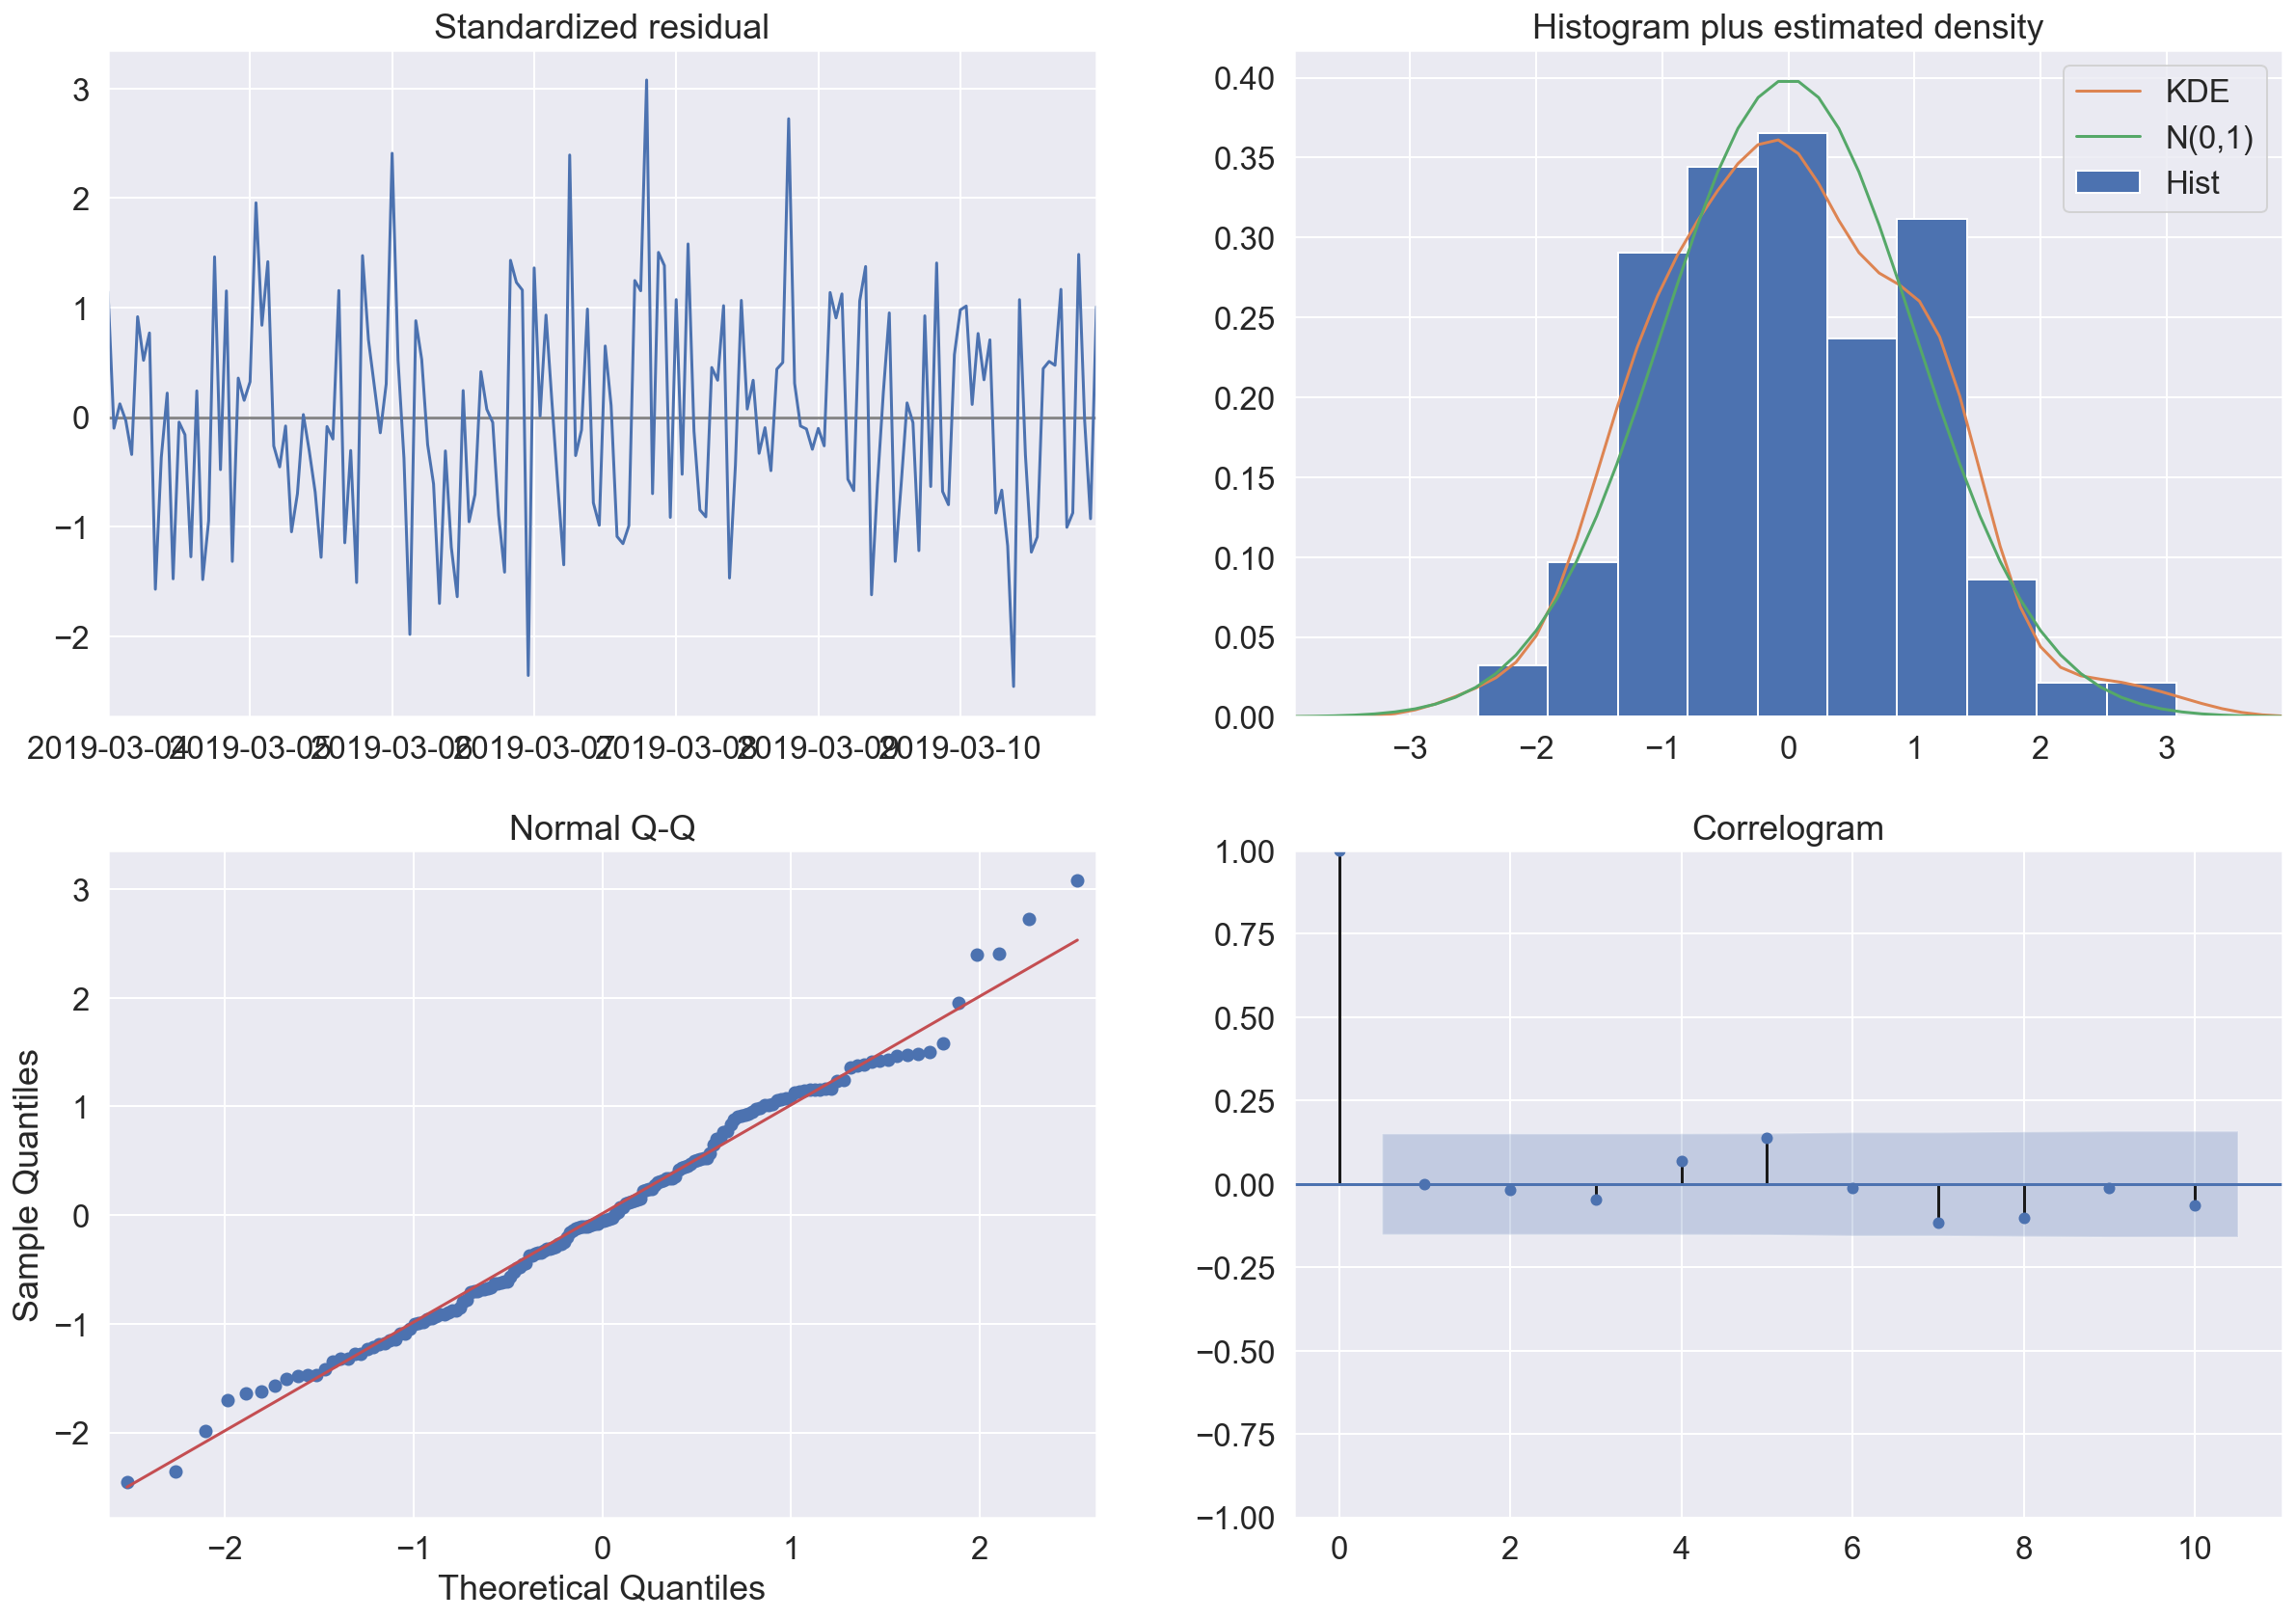

In [46]:
g = hospital_results.plot_diagnostics(figsize=(18,14));

The first plot shows the residuals as we printed before. The second upper plot shows the distribution of the residuals' values. They should be ideally centered around zero and distributed according to a Gaussian. Thus, the plot also reports the kernel density estimation and the ideal N(0,1). The Q-Q plot in the left bottom corner should have all the residuals aligned and as it can be seen, this is almost the case. The ACF on the bottom right represents the typical plot for white noise. Thus residuals are almost normally distributed unpredictable white noise and we should be satisfied.

We now repeat the same procedure for data measuring the milk production.

In [47]:
milk_production = pd.read_csv('others/milk_production.csv', index_col='Month', parse_dates=['Month'])
milk_production_model = SARIMAX(milk_production, order=(3,1,2))
milk_production_results = milk_production_model.fit()

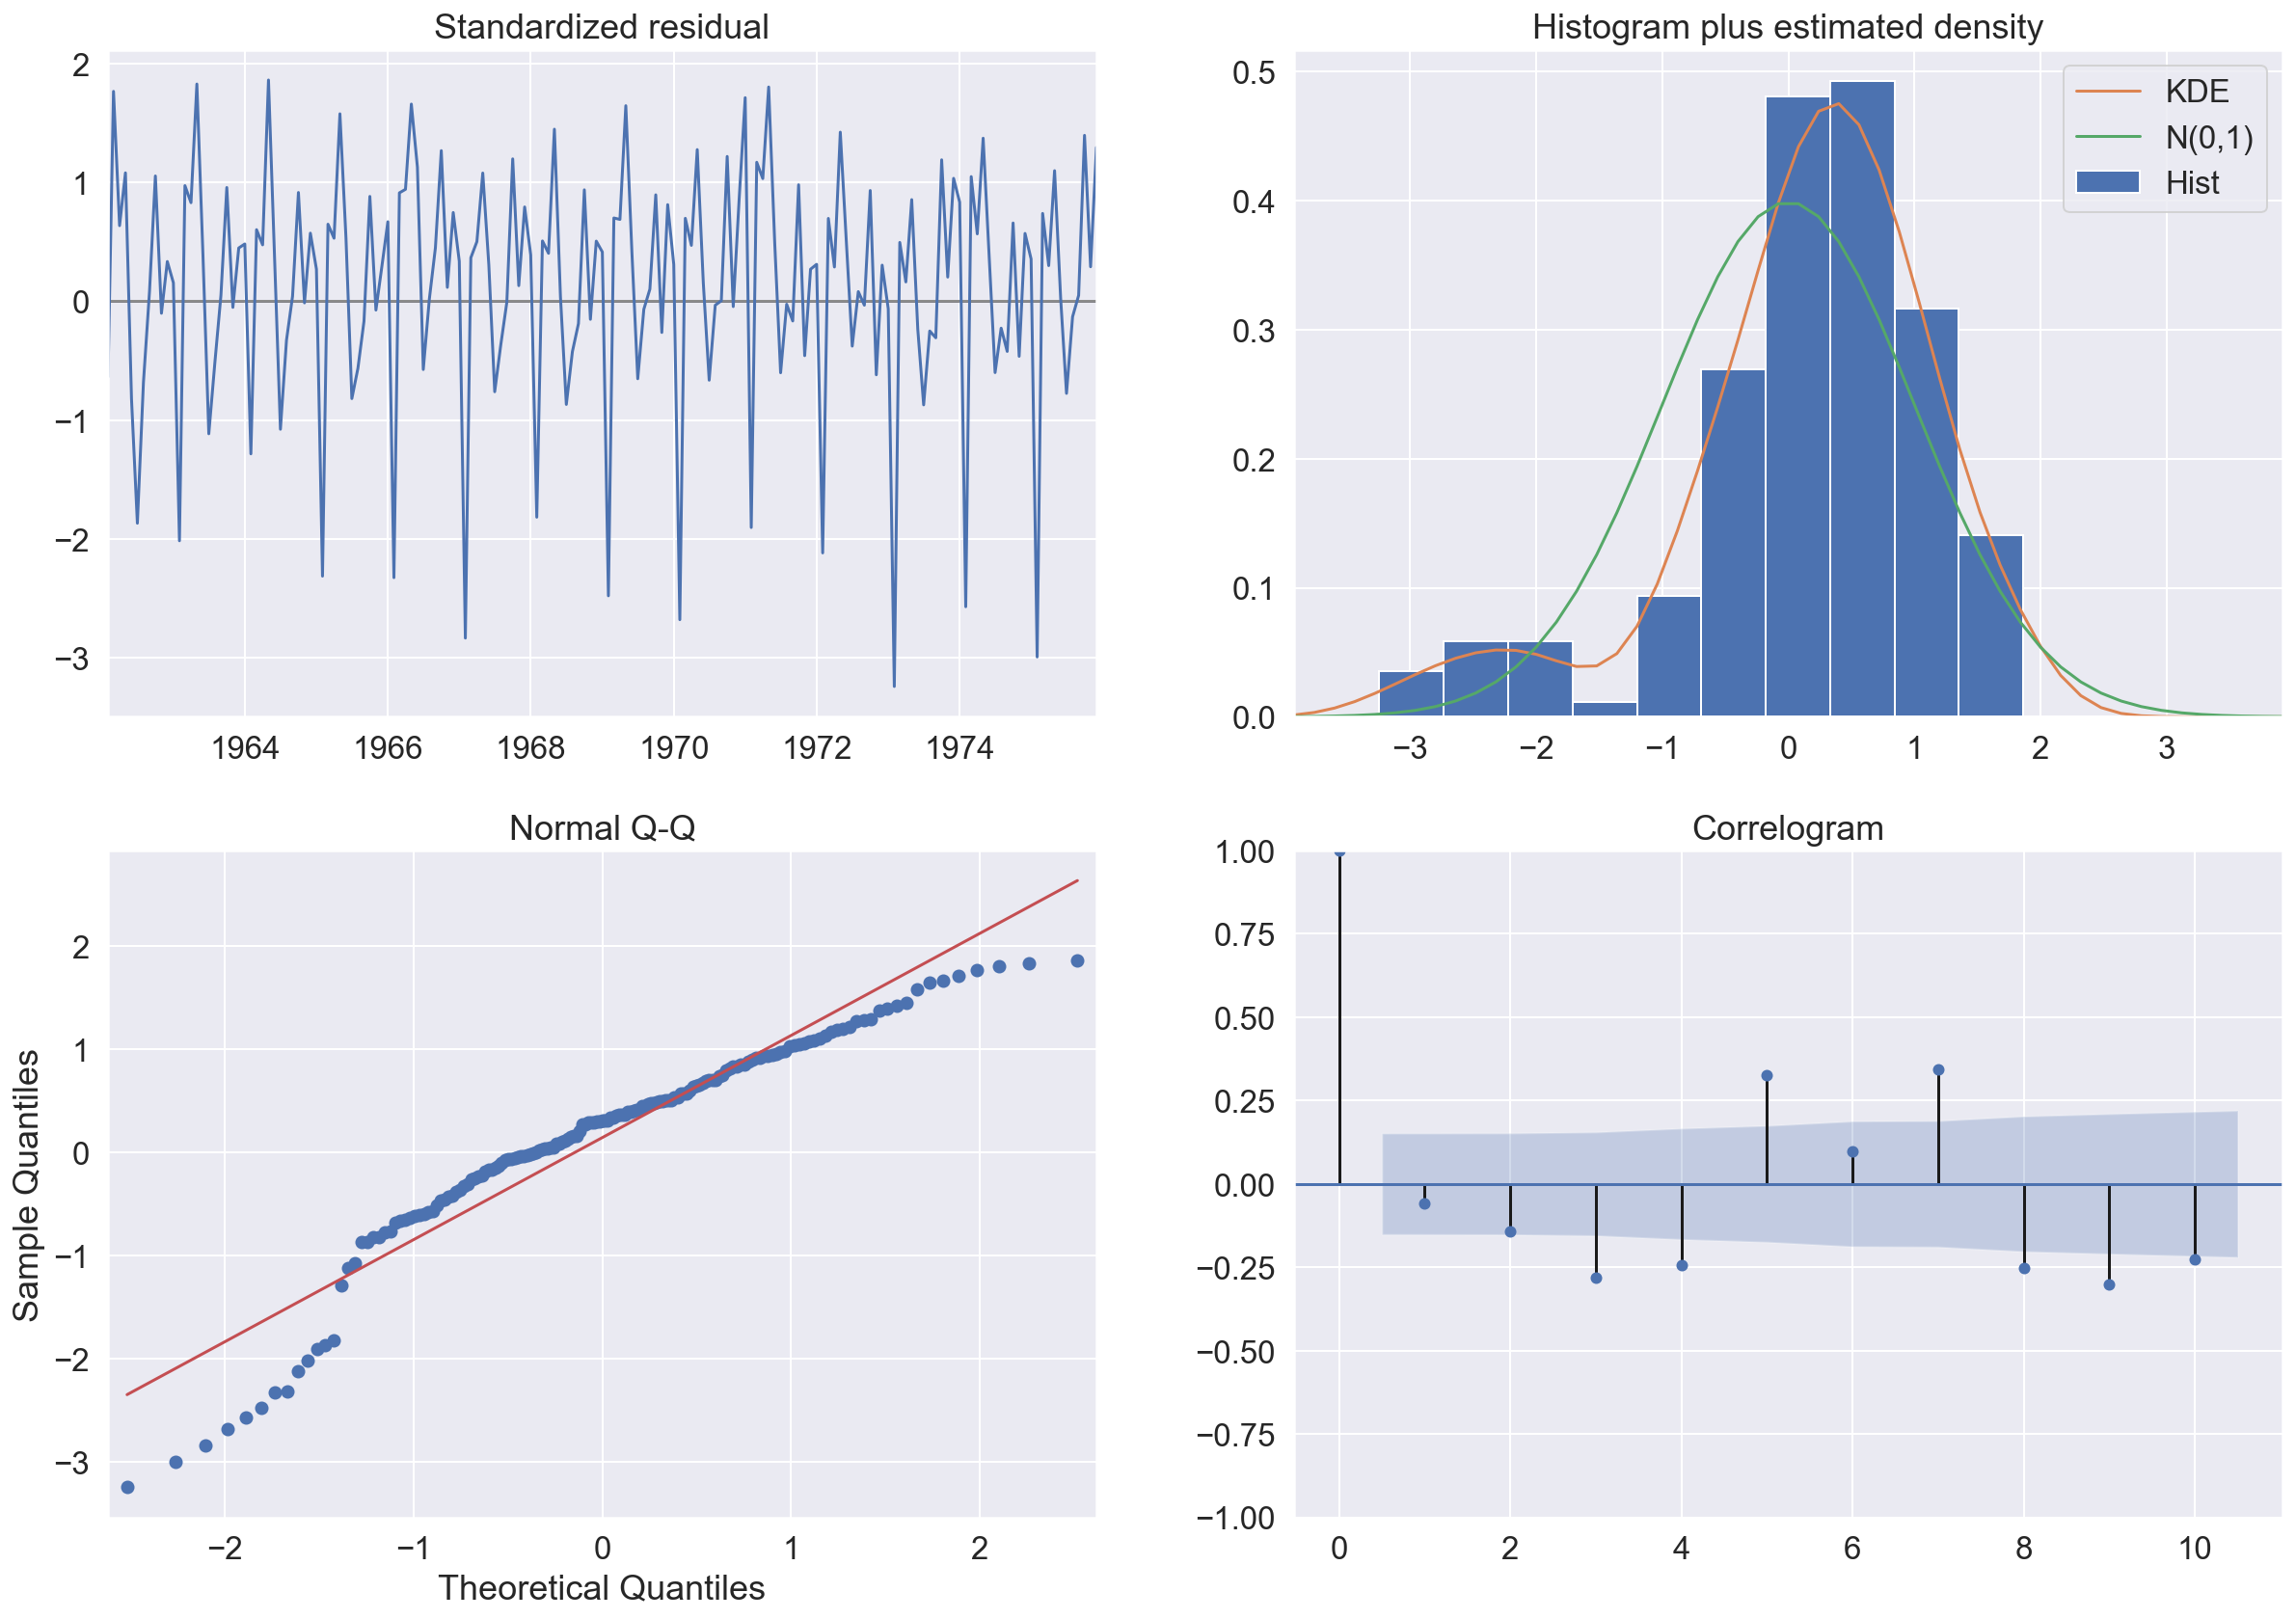

In [48]:
g = milk_production_results.plot_diagnostics(figsize=(18,14));

Note that the residuals show some repeated pattern (seasonality) in addition, KDE and N(0,1) should basically overlap but they don't. Most importangly, the correlogram shows some peaks for some lags suggesting that the model is not capturing all the information of the series and some is still contained in the residuals.

# Model Selection
So far, we fitted data from simulated known AR and MA processes. We now move forward and try to fit real data for which an underlying model is unknown or non-existant. In this scenario, we need to choose (identify) the best parameters (the orders of AR and MA) for modeling our data. There are two main approaches: partial autocorrelation function and information criteria. 

Partial autocorrelation function evaluates the benefit of adding more lags to our model incrementally. 

In [49]:
ar_examples = pd.read_csv('others/arma_examples.csv',index_col='Index')

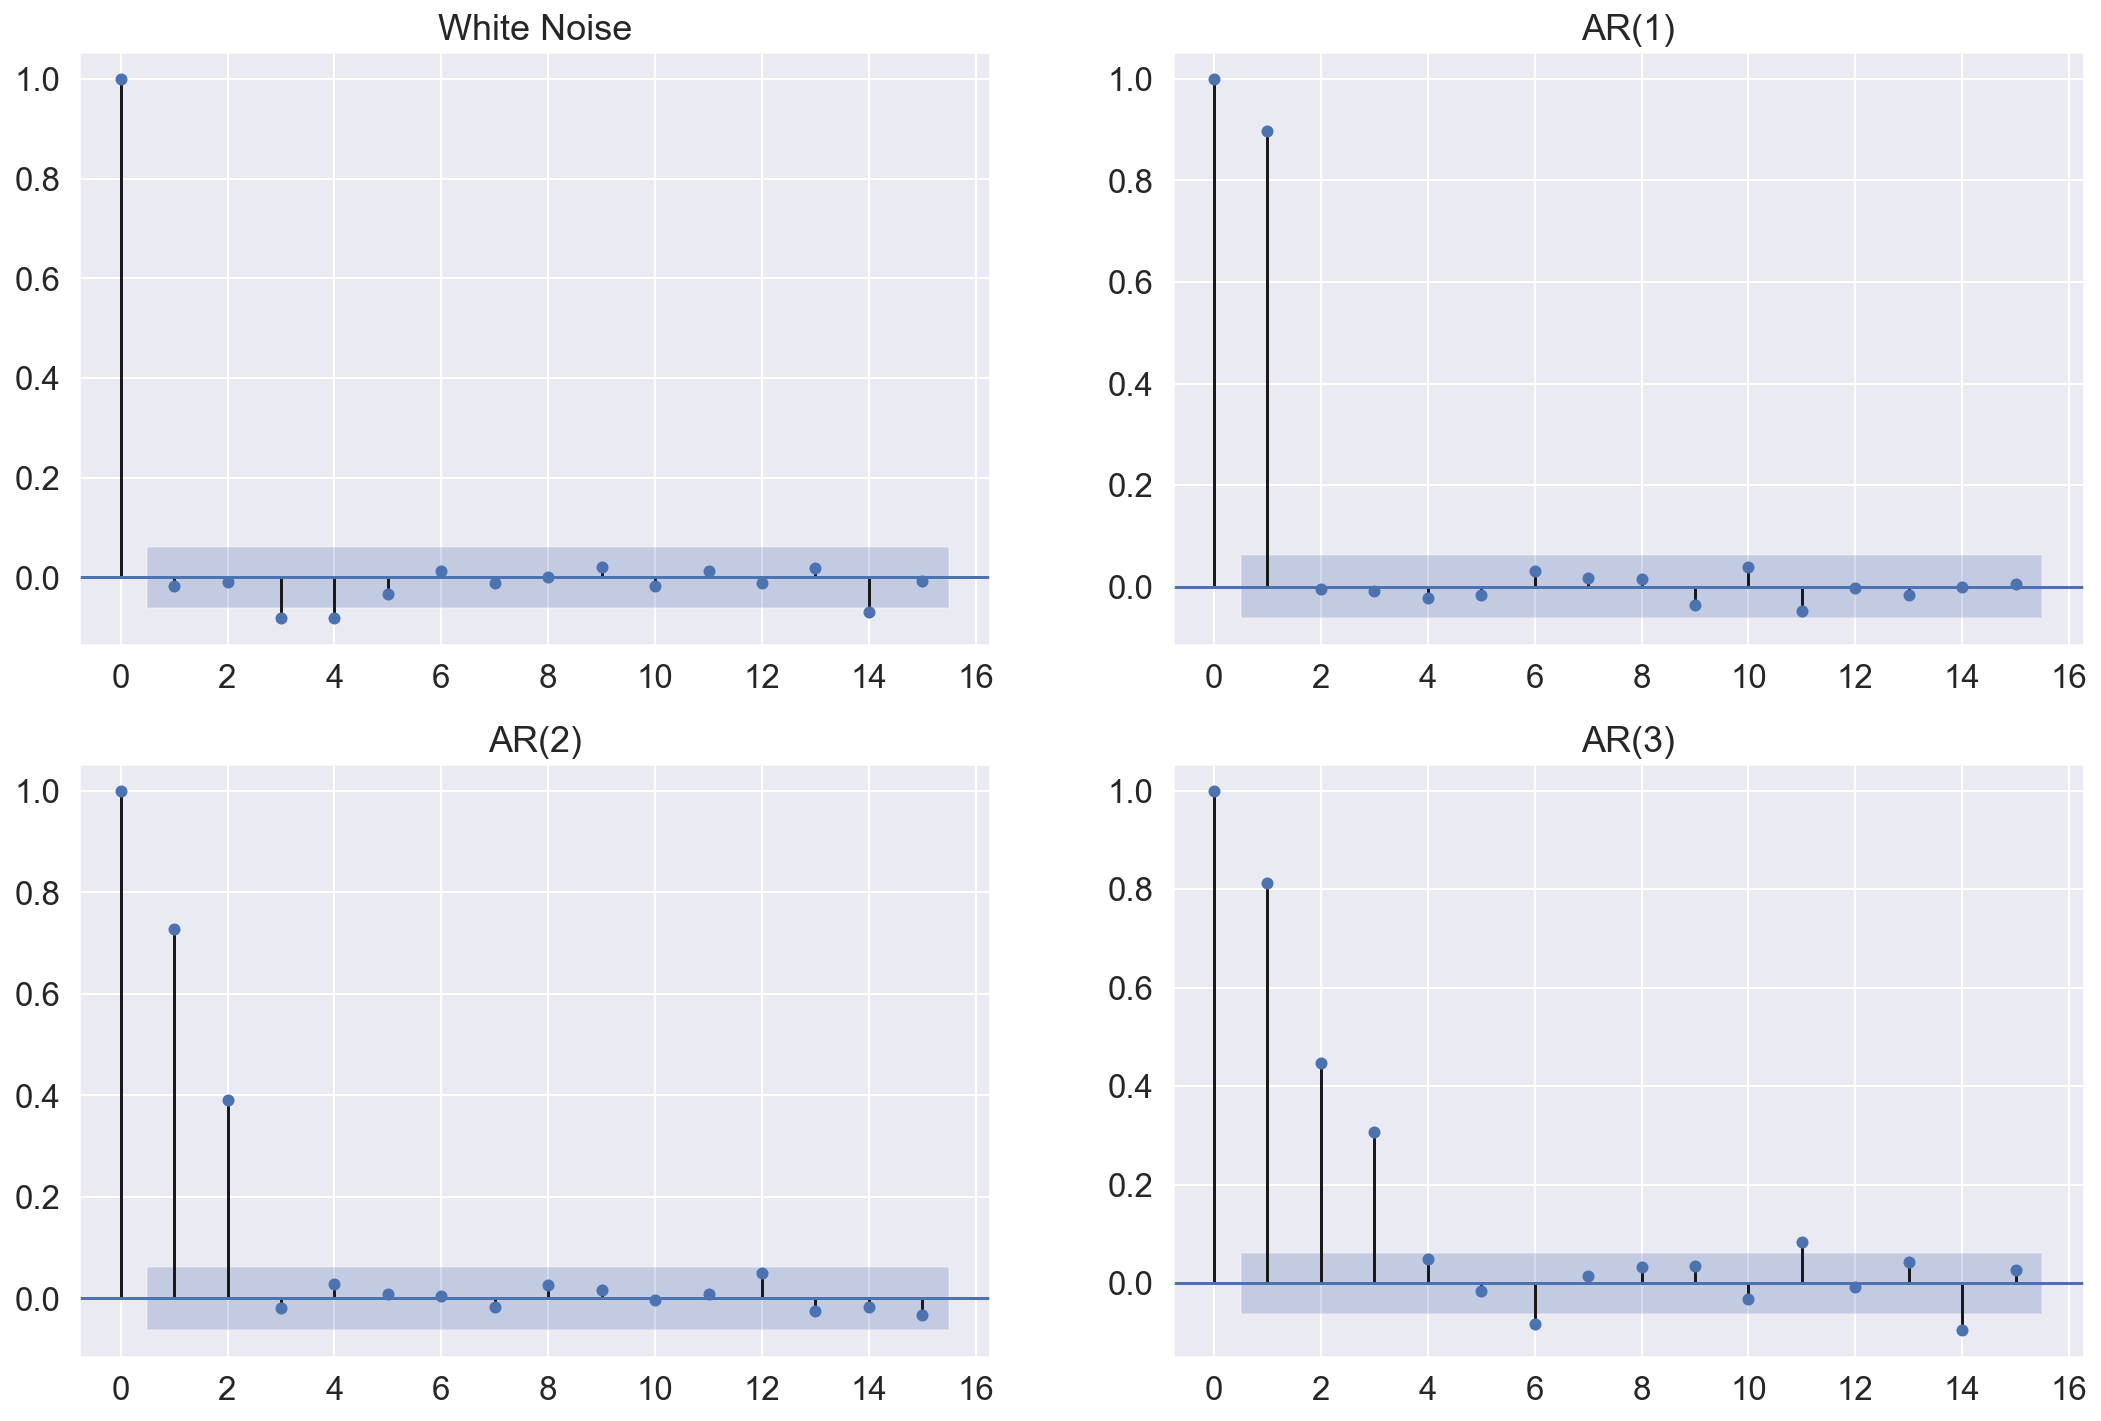

In [50]:
fig, ax = plt.subplots(2,2,figsize=(16,12))

ax = plt.subplot(2,2,1)
plot_pacf(ar_examples['Noise'], alpha=.05,lags=15, ax=ax)
plt.title("White Noise")

ax = plt.subplot(2,2,2)
plot_pacf(ar_examples['AR(1)'], alpha=.05,lags=15, ax=ax)
plt.title("AR(1)")

ax = plt.subplot(2,2,3)
plot_pacf(ar_examples['AR(2)'], alpha=.05,lags=15, ax=ax)
plt.title("AR(2)")

ax = plt.subplot(2,2,4)
plot_pacf(ar_examples['AR(3)'], alpha=.05,lags=15, ax=ax)
plt.title("AR(3)")

plt.show()

Note that, for white noise (upper left plot) there are no significant lags. In contrast, for AR(1) model only the lag 1 in PACF is significantly different from zero, meaning that there is not advantage in adding further terms to model these data. Similarly, for AR(2) and AR(3) there are respectively 2 and 3 lags that are significantly different from zero.

We can compare ACF and PACF to choose the model order and to understand what type of model we are analyzing. For instance, if ACF tails off and PACF cuts off after a certain lag p, then we are dealing with an AR(p) model. For instance, the plots below are from an AR(2) model.

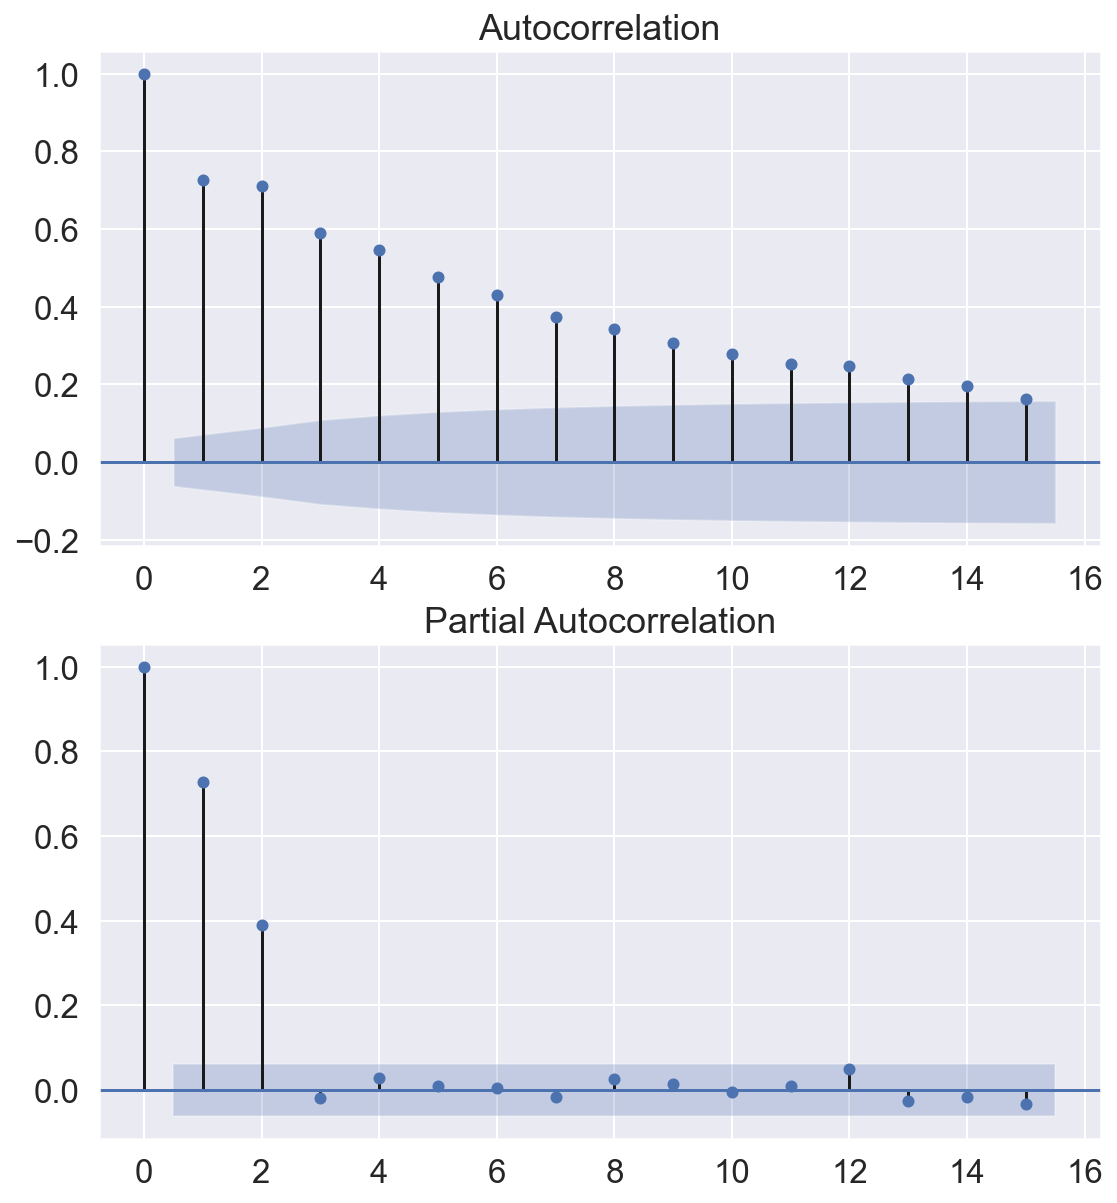

In [51]:
fig, ax = plt.subplots(2,1,figsize=(8,10))
ax = plt.subplot(2,1,1)
plot_acf(ar_examples['AR(2)'], alpha=.05,lags=15, ax=ax)

ax = plt.subplot(2,1,2)
g=plot_pacf(ar_examples['AR(2)'], alpha=.05,lags=15, ax=ax)

In contrast, if ACF cuts off after a certain lag q while PACF tails off, then we are dealing with an MA(q) model. For instance, the plots below are from an MA(3) model.

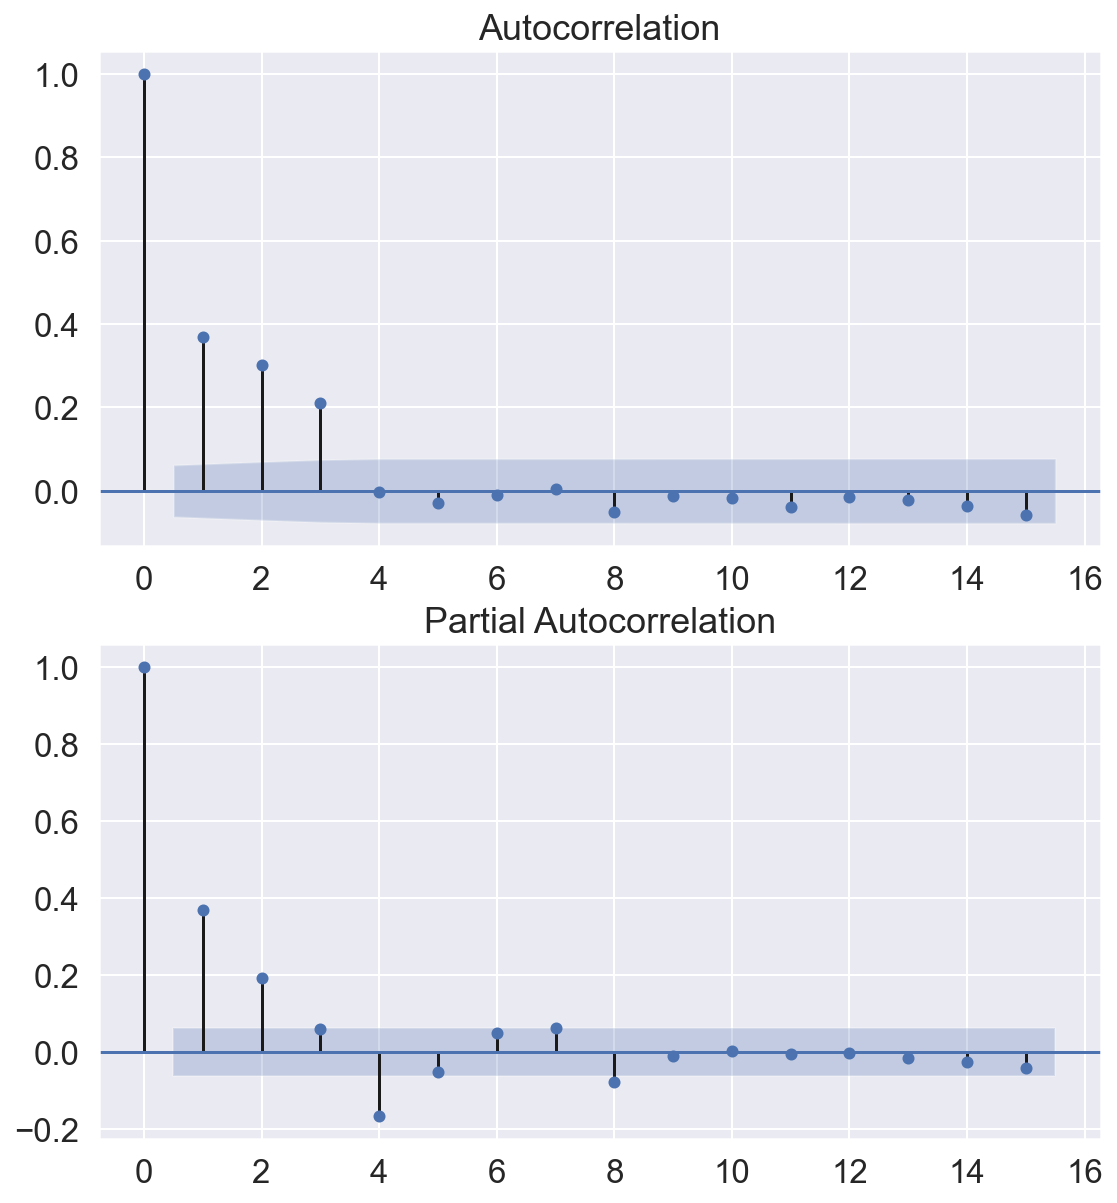

In [52]:
fig, ax = plt.subplots(2,1,figsize=(8,10))
ax = plt.subplot(2,1,1)
plot_acf(ar_examples['MA(3)'], alpha=.05,lags=15, ax=ax)

ax = plt.subplot(2,1,2)
g=plot_pacf(ar_examples['MA(3)'], alpha=.05,lags=15, ax=ax)

If both ACF and PCF tail off, then we are dealing with an ARMA model but we cannot use the plots to deduce the order of the two models. The plots below are from an ARMA(4,3) model.

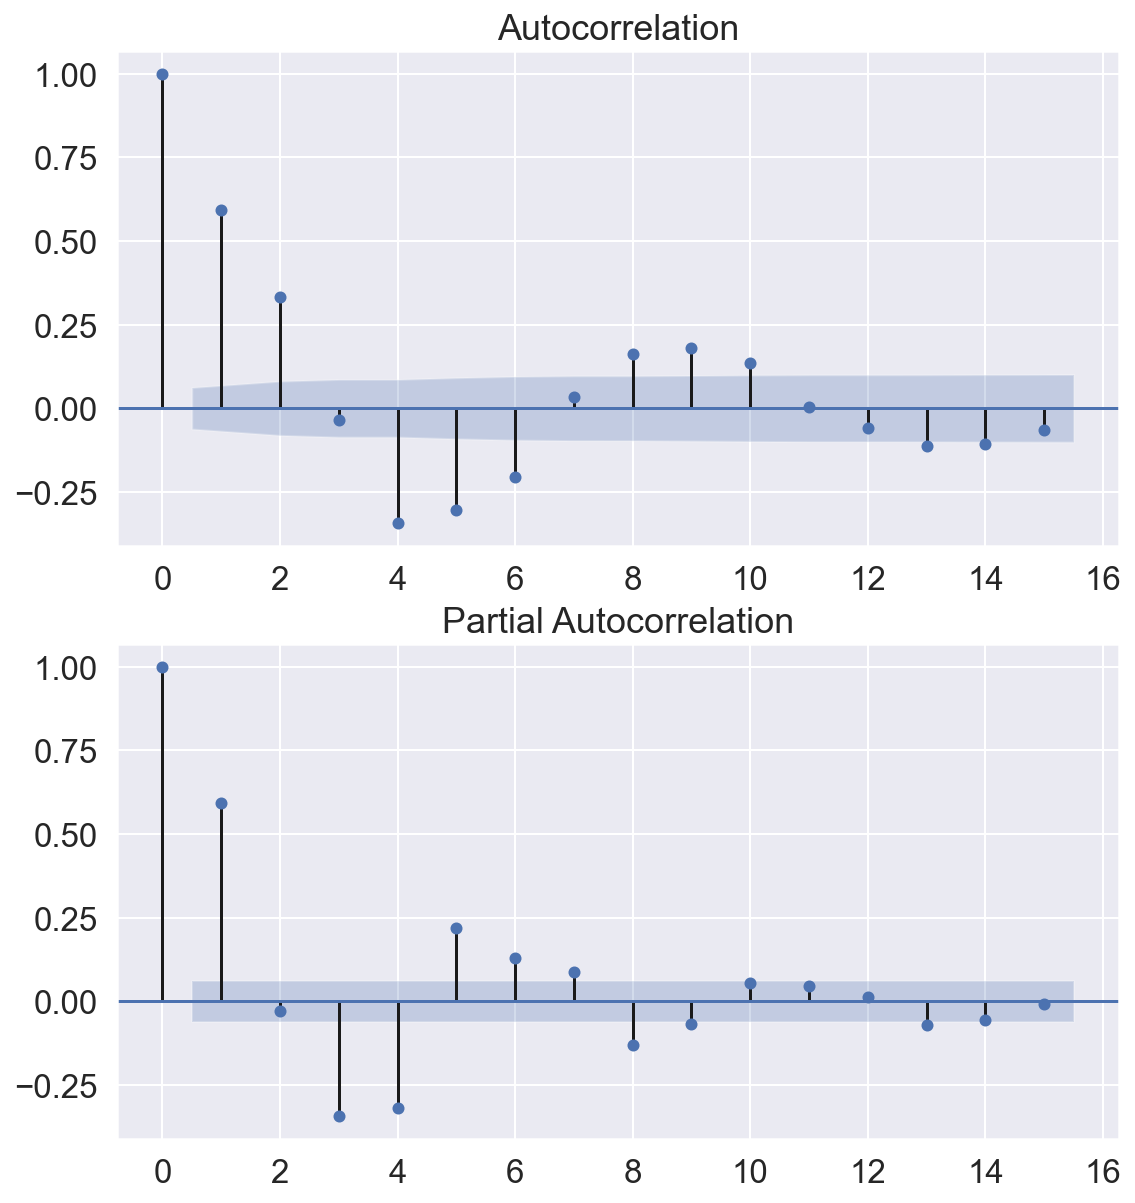

In [53]:
fig, ax = plt.subplots(2,1,figsize=(8,10))
ax = plt.subplot(2,1,1)
plot_acf(ar_examples['ARMA(4,3)'], alpha=.05,lags=15, ax=ax)

ax = plt.subplot(2,1,2)
g=plot_pacf(ar_examples['ARMA(4,3)'], alpha=.05,lags=15, ax=ax)

## Bayesian Information Criterion
Given some data, the more the parameters the better the fitting but this can also lead to overfitting the data. *Information Criteria* helps avoiding overfitting by penalizing the number of parameter used while adjusting the goodness-of-fit. Bayesian Information Criterion is a popular adjusted goodness-of-fit measure. Schwarz’s Bayesian Information Criterion is defined as, 

$$
BIC = T \log(\frac{SSE}{T})+(k+2)\log(T)
$$

Where $T$ is the number of observation used for estimation and $k$ is the number of parameters used in the model. $k+2$ includes the $k$ coefficients, the intercept, and the variance of the residuals. Alternatives to BIC are (1) the corrected Akaike’s Information Criterion (AIC) and (2) adjusted $R^2$ (see [Hyndman and Athanasopoulos book](https://otexts.com/fpp2/)). AIC and BIC often choose the same model. BIC favors simpler models than AIC. If our goal is to identify a good predictive model, we should use AIC. If our goal is to select a good explanatory model we should use BIC.

We apply BIC to find the number of parameters for some real data. We consider the AMZN stock and sample it daily. Since we don't have the information for all the days, some will be missing so we fill the missing values with previous valid values (ffill). We consider the first difference of closing price and eliminate the initial null. 

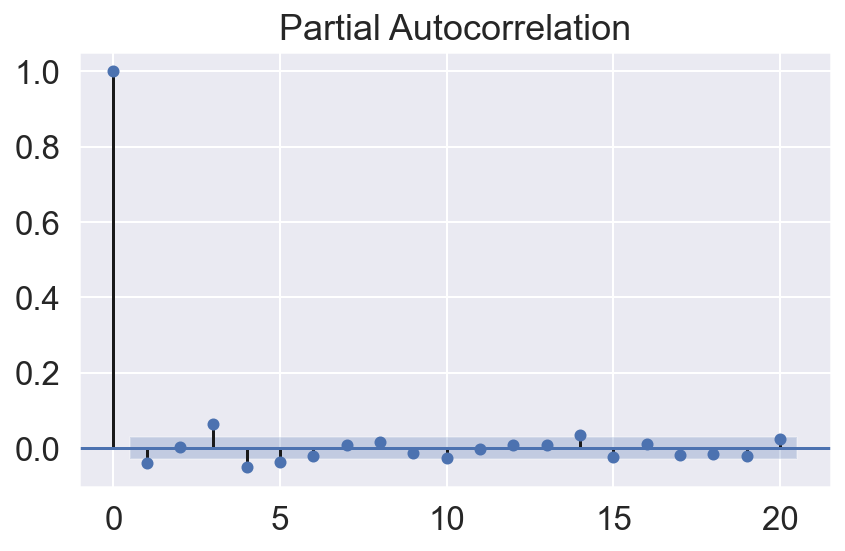

In [54]:
amazon_daily = amazon.asfreq('D', method='ffill').Close.diff().dropna()
fig = plot_pacf(amazon_daily, lags=20, alpha=0.05)

Now, we consider all the AR model up to order 8 and for each one we are going to fit the model and track the value of the Bayesian Information Criterion and select the model that minimizes it.

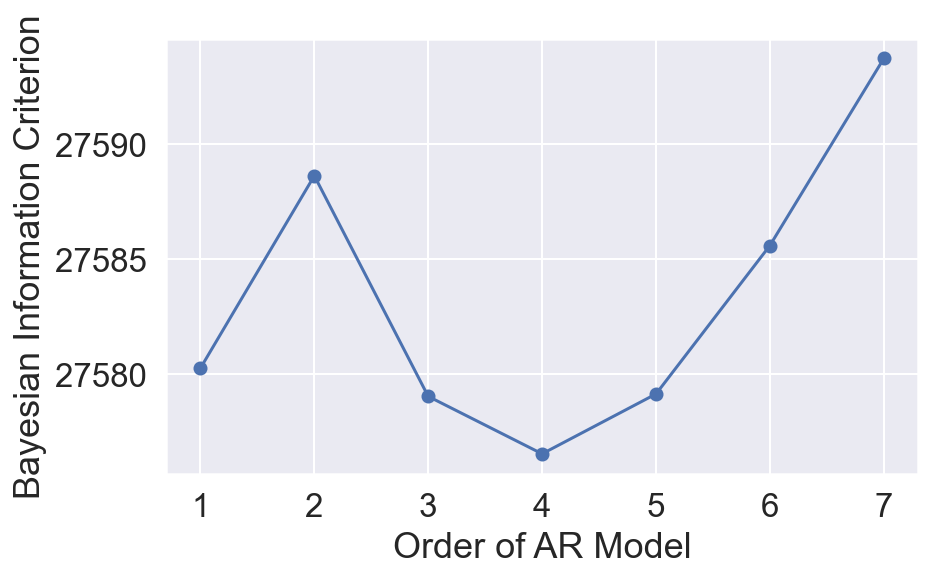

In [55]:
max_model_order = 8
BIC = np.zeros(max_model_order)
AIC = np.zeros(max_model_order)
for ar_order in range(max_model_order):
    model = ARMA(amazon_daily, order=(ar_order,0))
    result = model.fit()
    
    BIC[ar_order] = result.bic
    AIC[ar_order] = result.aic
    
plt.plot(range(1,max_model_order), BIC[1:max_model_order], marker='o')
plt.xlabel('Order of AR Model');
plt.ylabel('Bayesian Information Criterion');
plt.show()

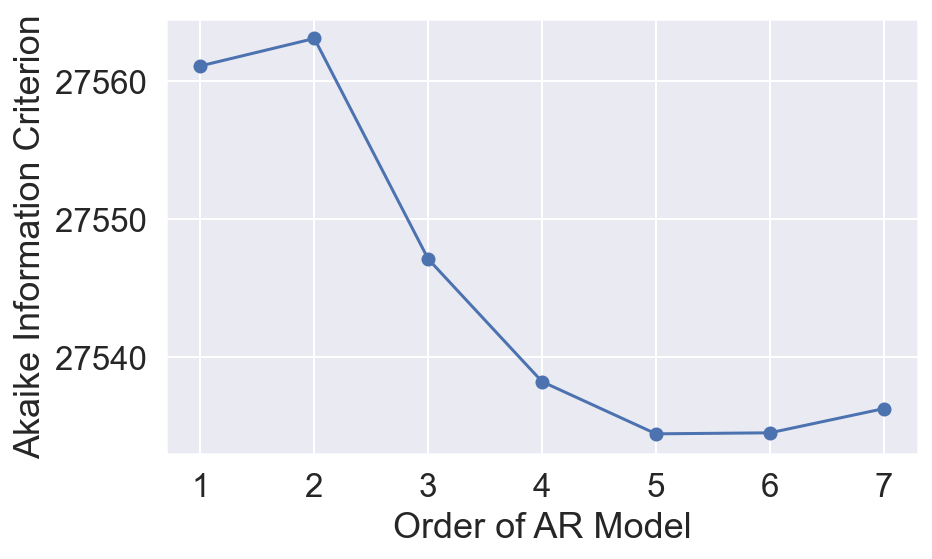

In [56]:
plt.plot(range(1,max_model_order), AIC[1:max_model_order], marker='o')
plt.xlabel('Order of AR Model');
plt.ylabel('Akaike Information Criterion');
plt.show()

Accordingly, with BIC we would select a model of order 4 which corresponds to the lowest BIC value whereas with AIC we would select a model of order 5.

We can also perform a grid search to find the best configuration for AR and MA parts of the ARMA model and use AIC and BIC to select the best parameter set.

In [57]:
p = []
q = []
bic = []
aic = []

for ar_order in range(4):
    for ma_order in range(4):
        model = ARMA(amazon_daily,order=(ar_order,ma_order))
        result = model.fit()
        
        p.append(ar_order)
        q.append(ma_order)
        bic.append(result.bic)
        aic.append(result.aic)
        
gridsearch = pd.DataFrame({'AR(p)':p,'MA(q)':q,'AIC':aic,'BIC':bic})

In [58]:
gridsearch.sort_values(by='AIC',ascending=True).head()

AR(p)  MA(q)           AIC           BIC
15      3      3  27538.524966  27589.599744
11      2      3  27541.718308  27586.408738
10      2      2  27542.527810  27580.833893
14      3      2  27543.208788  27587.899219
7       1      3  27543.522542  27581.828625

In [59]:
gridsearch.sort_values(by='BIC',ascending=True).head()

AR(p)  MA(q)           AIC           BIC
0       0      0  27565.579235  27578.347930
12      3      0  27547.102741  27579.024477
3       0      3  27548.291178  27580.212914
4       1      0  27561.098760  27580.251802
1       0      1  27561.160087  27580.313129

As before BIC selected the simpler model (maybe even too simple!)

## Automatic Search of the Model Parameters
Instead of searching for the model parameter ourselves, we can use the function [*auto_arima*](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) from the pmdarima library that can automatically discover the optimal order for an ARIMA model. Let's apply it to the previous example. The function takes several parameters that allows to customize the search for all the models we have seen and even more.

In [64]:
import pmdarima as pm
results = pm.auto_arima(amazon_daily)

In [65]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4378
Model:               SARIMAX(5, 1, 0)   Log Likelihood              -14132.048
Date:                Tue, 17 Nov 2020   AIC                          28276.097
Time:                        19:11:16   BIC                          28314.401
Sample:                             0   HQIC                         28289.613
                               - 4378                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8547      0.007   -120.814      0.000      -0.869      -0.841
ar.L2         -0.6658      0.010    -65.573      0.000      -0.686      -0.646
ar.L3         -0.4296      0.011    -40.609      0.000      -0.450      -0.409
ar.L4         -0.3080      0.009    -33.139      0.000      -0.326      -0.290
ar.L5         -0.1619      0.006    -25.572      0.000      -0.174      -0.149
sigma2        37.3079      0.154    242.752      0.000      37.007      37.609
===================================================================================
Ljung-Box (Q):                      306.13   Jarque-Bera (JB):            641851.89
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              22.83   Skew:                             2.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        62.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The search returned an ARIMA(3,1,1) model. We can also check the residual diagnostics.

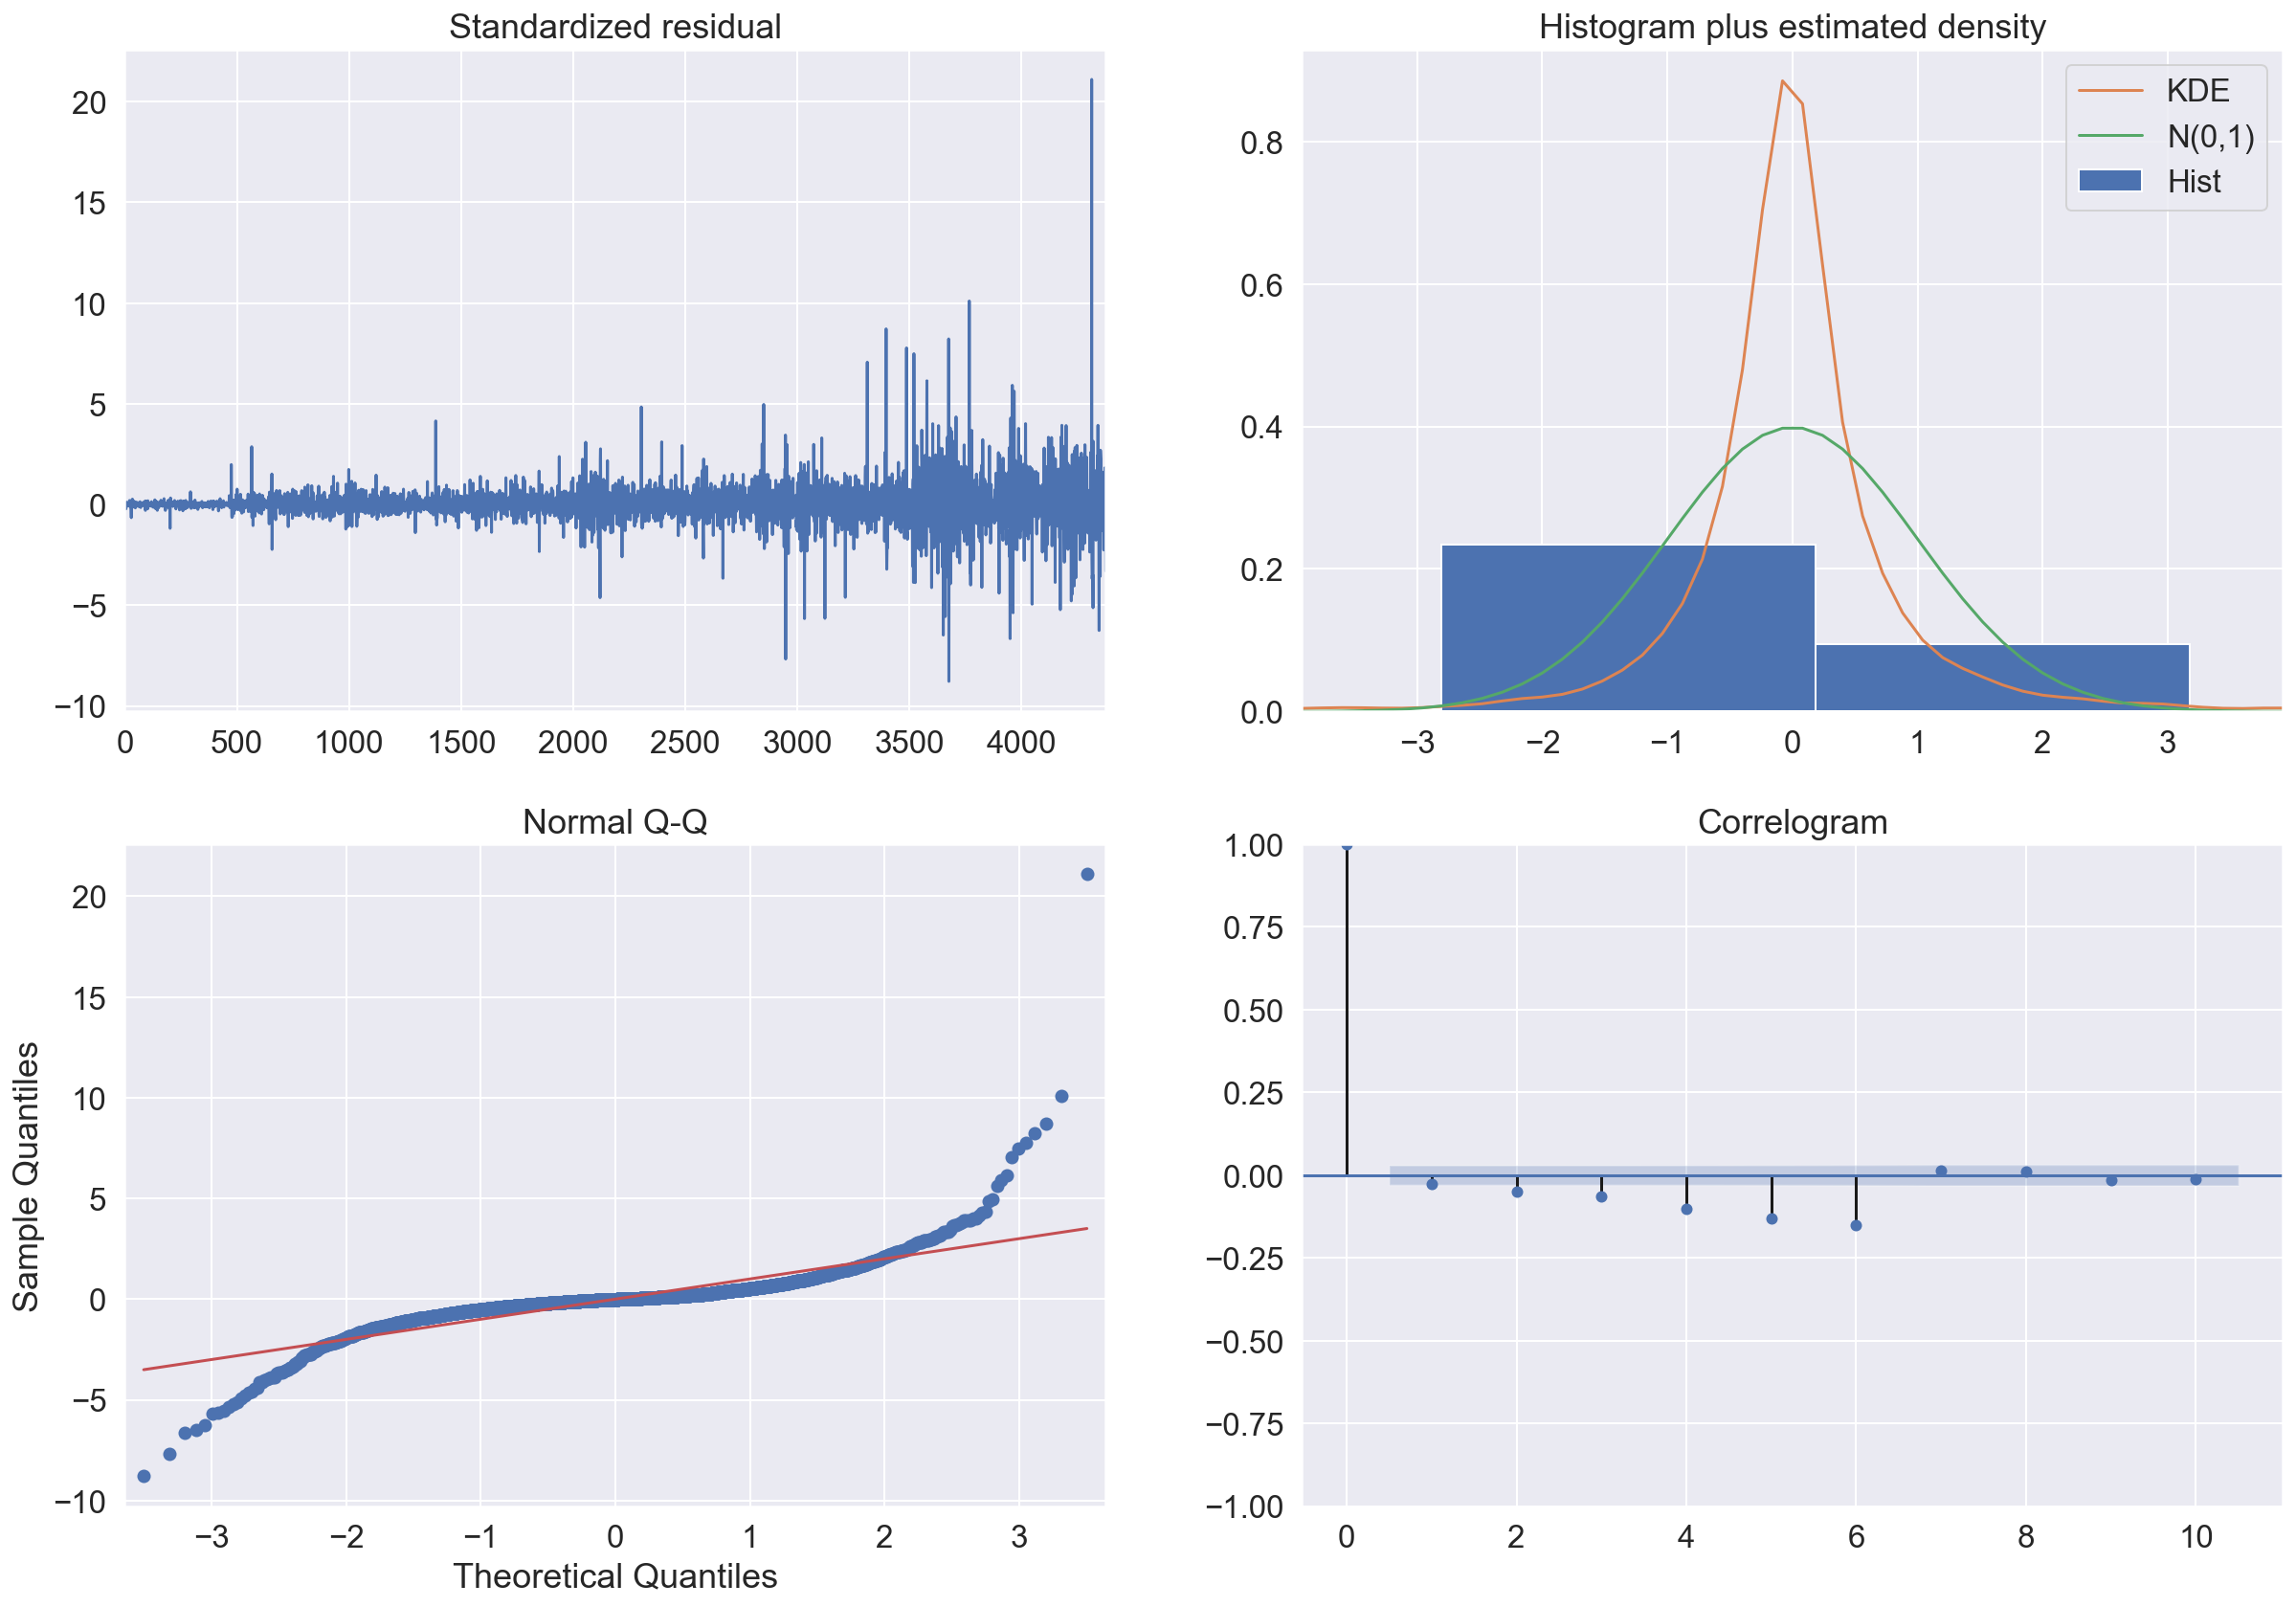

In [66]:
g=results.plot_diagnostics(figsize=(18,14))

As can be noted, the residuals show some issues regarding their value distribution and ACF. Accordingly, we might want to analyze the data and perform some preprocessing on them to check for stationarity, etc. 

# Box-Jenkins Method
It provides a sequences of steps that you should perform to identify, fit and check time-series data using integrated autoregressive, moving average (ARIMA) time series models. It is an iterative approach based on three main steps:

1. *Identification*: we check whether the series is stationary (e.g., using the Augmented Dicky-Fuller test) and in case it is not we apply adequate transformations (e.g., using diff(), log(), sqrt()) to make it stationary. Next, we try to estimate the most promising values for the order of the AR and MA components (e.g., using ACF/PACF).

2. *Estimation*: we use the data to train the model (using fit()) and estimates the model coefficients. We can explore the space of possible models by using AIC and BIC.

3. *Model Diagnostics*: we check whether the residuals are uncorrelated and normally distributed (e.g. using summary() and plot_diagnostics() functions)

4. *Decision*: we finally have to decide whether we are satisfied with the model. If we are, the process can stop, we found the model we were looking for and we can move to the production step. If we are not, then we go back and iterate. 